In [76]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt


#Agent的行動
class Actions(Enum):
    Sell = 0
    Buy = 1

#在Env裡面所代表的
class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long

    
class TradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}
    
    #__init__為魔法函數，意義為：無論你願不願意，只要你執行TradingEnv，就會把__init__底下的資料執行，可以用作變數定義？
    def __init__(self, df, window_size): 
        assert df.ndim == 2 #判斷所輸入的df維度是否等於2

        self.seed() #隨機種子設定
        self.df = df #輸入df
        self.window_size = window_size #輸入Windows size
        self.open, self.close, self.high, self.low, self.volume, self.signal_features = self._process_data() #輸入【價錢, 特征資料】
        self.shape = (window_size, self.signal_features.shape[1]) #輸入【Windows size, 特征資料的長度】

        # spaces
        self.action_space = spaces.Discrete(len(Actions)) # 行動空間為：2（Sell、Buy）
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64) #觀察空間最低和最高為無限（因為不知股票價錢為多少）

        # episode
        #「_」為私有化，即import的時候不會引入參數
        self._start_tick = self.window_size #開始日期：Windows_size設定的數字
        self._end_tick = len(self.close)-1 #結束日期：【價錢】的長度-1
        self._done = None 
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓        
        self._reward_history = []#記錄Reward獎勵，方便畫圖
        self._Total_profit = []#記錄Profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None

    #定義一個隨機種子   
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    #重設
    def reset(self):
        self._done = False #尚未完成
        self._current_tick = self._start_tick # Windows_size設定的數字
        self._last_trade_tick = self._current_tick -1 #Windows_size設定的數字-1
        self._position = Positions.Short #第一天交易必定為Short
        self._position_history = (self.window_size * [None]) + [self._position] #記錄位置
        self._total_reward = 0. #初始化的reward為：0
        self._total_profit = 1. #初始化的Profit為：1
        self._first_rendering = True
        self.history = {}
        return self._get_observation()

    #交易中的步驟
    def step(self, action):
        self._done = False #尚未完成動作
        
        
        #如果當前日期 = 完結日期，就結束步驟
        if self._current_tick == self._end_tick:
            self._done = True

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
#如果機器人進行買的動作，他的Position就會變成Long，反之亦然
        if(action == Actions.Buy.value):
            self._position = Positions.Long
#             print("action: ", action)
#             print("position: ", self._position)
        elif(action == Actions.Sell.value):
            self._position = Positions.Short
#             print("action: ", action)
#             print("position: ", self._position)
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑               
        self._last_trade_tick = self._current_tick      
        #記錄步驟
        self._position_history.append(self._position)
        
        #獎勵：調用計算獎勵的function，然後將它累積起來計算總和
        step_reward = self._calculate_reward(action)
        step_profit = self._update_profit(action)#記錄profit，方便畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
        self._reward_history.append(step_reward)#記錄Reward獎勵，方便畫圖
        self._Total_profit.append(step_profit)#記錄profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ 
        self._total_reward += step_reward
        #根據agent的action更新他的 profit
        
        
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)
        
        self._current_tick += 1 #當前日期+1

        return observation, step_reward, self._done, info

    #取得觀察值，觀察值為signal_features
    #若window_size為10
    #則使用0 ~ 9日的觀察值，下一次交易則使用1 ~ 10日的觀察值
    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]

    #更新歷史資料
    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    #render：將環境實體化，以股票交易為例即是畫圖
    def render(self, mode='human'):
        pass


    #畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓    
    def render_Close(self, mode='human'):
            window_ticks = np.arange(len(self._position_history))#[1,2,3,4,5,....]矩陣
            plt.plot(self.close)#根據收盤價進行繪畫

            short_ticks = []
            long_ticks = []
            # i：控制position_history的位置
            # tick：控制要塞進Long還是Short的位置
            #如果機器人在之前就是做Long的話就把它記錄在long_ticks裡面，反之亦然
            for i, tick in enumerate(window_ticks-1):
                if self._position_history[i] == Positions.Short:
                    short_ticks.append(tick)
                elif self._position_history[i] == Positions.Long:
                    long_ticks.append(tick)      

            del(short_ticks[0])

            plt.plot(short_ticks, self.close[short_ticks], 'ro', label = 'Short')#根據收盤價進行畫圖
            plt.plot(long_ticks, self.close[long_ticks], 'go', label = 'Long')#根據收盤價進行畫圖
            
            plt.legend()
            plt.title("Close", fontsize=20)
            plt.suptitle(
                "Total Reward: %.6f" % self._total_reward + ' ~ ' +
                "Total Profit: %.6f" % self._total_profit
            )
            print("↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓")
        
        
    #畫圖2   
    def render_Reward(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks-1):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)
        
        del(short_ticks[0])
        self._reward_history = np.array(self._reward_history)
        short_ticks = (np.array(short_ticks)-10).tolist()
        long_ticks = (np.array(long_ticks)-10).tolist()
        
        plt.bar(short_ticks,self._reward_history[short_ticks], color='r', label = 'Short')#根據獎勵進行繪畫
        plt.bar(long_ticks,self._reward_history[long_ticks], color='g', label = 'Long')#根據獎勵進行繪畫
            
        plt.legend()   
        plt.title("Reward", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓")
        
        
    def render_TotalProfit(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        
        del self._Total_profit[-1]
        plt.plot(self._Total_profit)
        
        
#         short_ticks = []
#         long_ticks = []
#         for i, tick in enumerate(window_ticks-1):
#             if self._position_history[i] == Positions.Short:
#                 short_ticks.append(tick)
#             elif self._position_history[i] == Positions.Long:
#                 long_ticks.append(tick)
        
#         del(short_ticks[0])
#         self._Total_profit = np.array(self._Total_profit)
#         short_ticks = (np.array(short_ticks)-10).tolist()
#         long_ticks = (np.array(long_ticks)-10).tolist()
        
#         plt.plot(short_ticks, self._Total_profit[short_ticks], 'ro', label = 'Short')#根據獎勵進行畫圖
#         plt.plot(long_ticks, self._Total_profit[long_ticks], 'go', label = 'Long')#根據獎勵進行畫圖
            
#         plt.legend() 

        plt.title("TotalProfit", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓")

        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑         
        


    
    
    #關閉環境，即關閉畫圖    
    def close(self):
        plt.close()

    #保存圖片
    def save_rendering(self, filepath):
        plt.savefig(filepath)

    #暫停畫圖
    def pause_rendering(self):
        plt.show()

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _process_data(self):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _calculate_reward(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _update_profit(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def max_possible_profit(self):  # trade fees are ignored
        pass

In [77]:
import numpy as np

class StocksEnv(TradingEnv):
    

    def __init__(self, df, window_size, frame_bound):
        assert len(frame_bound) == 2 #判斷所輸入的df維度是否等於2

        self.frame_bound = frame_bound #輸入範圍值
        super().__init__(df, window_size)

        self.trade_fee_percent = 0.001425+0.003
        #https://rich01.com/what-is-next-day-trading/
        
    #資料處理
    def _process_data(self):
        open = self.df.loc[:, 'open'].to_numpy() #prices：開市價
        close = self.df.loc[:, 'close'].to_numpy() #prices：收盤價
        high = self.df.loc[:, 'high'].to_numpy() #prices：最高
        low = self.df.loc[:, 'low'].to_numpy() #prices：最低
        volume = self.df.loc[:, 'volume'].to_numpy() #prices：成交量
        close[self.frame_bound[0] - self.window_size] # validate index (TODO: Improve validation)#驗證資料：10-10
        close = close[self.frame_bound[0]-self.window_size:self.frame_bound[1]]#【10-10:5600】

        diff = np.insert(np.diff(close), 0, 0)#計算價差【今天 - 昨天】
        signal_features = np.column_stack((close, diff))#默認的signal_features為：收盤價，價差

        return open, close ,high, low, volume, signal_features

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
    #計算獎勵
    def _calculate_reward(self, action):
        step_reward = 0
        price_diff = 0
       
        
        if(self._current_tick < self._end_tick):
            if(action == Actions.Buy.value):
                current_price = self.close[self._current_tick]*1000#【今天收盤】
                last_trade_price = self.open[self._current_tick+1]*1000#【明天開盤】
                
                Buy_trade_fee = (current_price * 0.001425)*0.5 #買入手續費 = (今天收盤 * 手續費） * 折扣
                if Buy_trade_fee<20:
                    Buy_trade_fee=20
                Sold_trade_fee = (last_trade_price * 0.001425)*0.5 #賣出手續費 = (明天開盤 * 手續費） * 折扣
                if Sold_trade_fee<20:
                    Sold_trade_fee=20
                Transfer_tax = last_trade_price * 0.003 #證交稅 = 明天開盤 * 稅率
                
                Buy = current_price + Buy_trade_fee#買入成本 = 今天收盤 + 買入手續費
                Sold = last_trade_price - Sold_trade_fee - Transfer_tax#賣出成本 = 明天開盤 - 賣出手續費 - 證交稅
                
                price_diff = (Sold - Buy)/Buy
                
                
                
            elif(action == Actions.Sell.value):
                current_price = self.close[self._current_tick]*1000#【今天收盤】
                last_trade_price = self.open[self._current_tick+1]*1000#【明天開盤】
                
                Buy_trade_fee = (last_trade_price * 0.001425)*0.5 #買入手續費 = (明天開盤 * 手續費） * 折扣
                if Buy_trade_fee<20:
                    Buy_trade_fee=20
                Sold_trade_fee = (current_price * 0.001425)*0.5 #賣出手續費 = (今天收盤 * 手續費） * 折扣
                if Sold_trade_fee<20:
                    Sold_trade_fee=20
                Transfer_tax = last_trade_price * 0.003 #證交稅 = 今天收盤 * 稅率
                
                Buy = last_trade_price + Buy_trade_fee #買入成本 = 明天開盤 + 買入手續費
                Sold = current_price - Sold_trade_fee - Transfer_tax#賣出成本 = 今天收盤 - 賣出手續費 - 證交稅
                
                price_diff = (Sold - Buy)/Buy
        
        step_reward =  step_reward + price_diff
        
        return step_reward


    def _update_profit(self, action):
        
        long_profit_percentage = 0.0
        short_profit_percentage = 0.0
        Total_long_profit_percentage = 0.0
        Total_short_profit_percentage = 0.0
        
        step_profit = 0
        if(self._current_tick < self._end_tick):
            if(action == Actions.Buy.value):
                
                current_price = self.close[self._current_tick]*1000#【今天收盤】
                last_trade_price = self.open[self._current_tick+1]*1000#【明天開盤】
                    
                Buy_trade_fee = (current_price * 0.001425)*0.5 #(買*手續費) * 證券商折扣
                if Buy_trade_fee<20:
                    Buy_trade_fee=20
                Sold_trade_fee = (last_trade_price * 0.001425)*0.5 #(賣*手續費) * 證券商折扣
                if Sold_trade_fee<20:
                    Sold_trade_fee=20
                Transfer_tax = last_trade_price * 0.003 #證交稅
                
                Buy = current_price + Buy_trade_fee#買入的成本
                Sold = last_trade_price - Sold_trade_fee - Transfer_tax#賣出的成本
                
                price_diff = Sold - Buy#最後賺到的錢
                long_profit_percentage = (Sold - Buy)/Buy
                self._total_profit += long_profit_percentage
                
            elif(action == Actions.Sell.value):

                current_price = self.close[self._current_tick]*1000#【今天收盤】
                last_trade_price = self.open[self._current_tick+1]*1000#【明天開盤】
                
                Buy_trade_fee = (last_trade_price * 0.001425)*0.5 #(買*手續費) * 證券商折扣
                if Buy_trade_fee<20:
                    Buy_trade_fee=20
                Sold_trade_fee = (current_price * 0.001425)*0.5 #(賣*手續費) * 證券商折扣
                if Sold_trade_fee<20:
                    Sold_trade_fee=20
                Transfer_tax = last_trade_price * 0.003 #證交稅
                
                Buy = last_trade_price + Buy_trade_fee#買入的成本
                Sold = current_price - Sold_trade_fee - Transfer_tax#賣出的成本
                
                price_diff = Sold - Buy#最後賺到的錢
                short_profit_percentage = (Sold - Buy)/Buy 
                self._total_profit += short_profit_percentage  
                       
                
        step_profit += self._total_profit #記錄profit，方便畫圖
        return step_profit#記錄profit，方便畫圖
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑  
                
    #https://github.com/AminHP/gym-anytrading/blob/master/README.ipynb
    #不論交易費用如何，agent在股票交易中所獲得的profit
    def max_possible_profit(self):
        pass

In [78]:
# import gym_anytrading
import numpy as np
import pandas as pd
import quantstats as qs
from stable_baselines import A2C

In [79]:
from yahoo_fin import stock_info as si
from sklearn.preprocessing import Normalizer
if isinstance('2330.TW', str):
    # load it from yahoo_fin library
    df = si.get_data('2330.TW')
df = df.dropna()#丟棄空值
df = df.reset_index()

#---------------------------------------------------------------------------
#定義參數

open = df['open']
close = df['close']
high = df['high']
low = df['low']
UpLine_max = []
UpLine = [] #上引線
DownLine_min = []
DownLine = [] #下引線
UpMean = []#計算RSI——上漲平均5天
DownMean = []#計算RSI——下跌平均5天
RSI = []#計算RSI
#---------------------------------------------------------------------------
#上引線；下引線

for i in range(close.size):
    UpLine_max.append(max(open[i], close[i]))
for i in range(close.size):
    UpLine.append(high[i] - UpLine_max[i])#上影線
for i in range(close.size):
    DownLine_min.append(min(open[i], close[i]))
for i in range(close.size):
    DownLine.append(DownLine_min[i] - low[i])#下影線
#---------------------------------------------------------------------------
#RSI

UpDownValue = close - close.shift(1) #計算漲跌值
Only_UpValue = pd.Series(index=UpDownValue.index, data=UpDownValue[UpDownValue>0])#將上漲日子篩出
Only_UpValue = Only_UpValue.fillna(0)#下跌的日子為0
Only_DownValue = pd.Series(index=UpDownValue.index, data=-UpDownValue[UpDownValue<0])#將下跌日子篩出
Only_DownValue = Only_DownValue.fillna(0)#上漲的日子為0
for i in range(13, len(Only_UpValue)+1):#由第六日開始，直到現在
    UpMean.append(np.mean(Only_UpValue.values[i-12:i]))#計算出最近五日的平均，因為有補0，所以可以計算出。
    DownMean.append(np.mean(Only_DownValue.values[i-12:i]))#計算出最近五日的平均
for i in range(len(UpMean)):
    RSI.append( (UpMean[i] / ( UpMean[i] + DownMean[i] )) * 100  )#計算RSI
RSI = pd.Series(index = close.index[12:], data = RSI) #轉換格式
#---------------------------------------------------------------------------
#FH；FL
FH = ((high - open) / open) #FH
FL = ((open - low) / open) #FL
FH = pd.DataFrame(FH, columns=['FH'])#FH參數
FL = pd.DataFrame(FL, columns=['FL'])#FL參數
#---------------------------------------------------------------------------
# KD
K = []
D = []
K_Value = []
D_Value = []
def RSV(df):
    df['MinLow'] = df['low'].rolling(9, min_periods=9).min()#9天最低位
    df['MinLow'].fillna(value = df['low'].expanding().min(), inplace = True)#填滿NA
    df['MaxHigh'] = df['high'].rolling(9, min_periods=9).max()#9天最高位
    df['MaxHigh'].fillna(value = df['high'].expanding().max(), inplace = True)#填滿NA
    df['RSV'] = (df['close'] - df['MinLow']) / (df['MaxHigh'] - df['MinLow']) * 100 #計算RSV
    return df
RSV_df = RSV(df)#使用RSV函數計算
RSV = RSV_df['RSV']#獲得RSV
for i in range(len(RSV)):
    if i<=9 :
        K.append(50)
        D.append(50)
    elif i > 9:
        K.append((K[i-1] * 2/3) + (1/3 * RSV[i]))
        D.append((D[i-1] * 2/3) + (1/3 * K[i]))
K_Value = pd.Series(index = close.index[0:], data = K) #轉換格式
D_Value = pd.Series(index = close.index[0:], data = D) #轉換格式
#---------------------------------------------------------------------------
# MACD
DIF = []
MACD = []
ShortEMA=close.ewm(span=12,adjust=False).mean()#12日移動平均
LongEMA=close.ewm(span=26,adjust=False).mean()#26日移動平均
FastLine_DIF=ShortEMA-LongEMA#DIF = （12日移動平均 - 26日移動平均）
SlowLine_MACD=FastLine_DIF.ewm(span=9,adjust=False).mean()#取DIF數值得到9日移動平均
FastLine_DIF = pd.DataFrame(FastLine_DIF)#轉換格式
SlowLine_MACD = pd.DataFrame(SlowLine_MACD)#轉換格式
FastLine_DIF = FastLine_DIF.rename(columns={'close':'DIF'})#轉換格式
SlowLine_MACD = SlowLine_MACD.rename(columns={'close':'MACD'})#轉換格式
#---------------------------------------------------------------------------                                                             
#BBands
def BBands(df,Day=20,Times=2):#20天平均, 2倍標準差
    Up_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Mid_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Down_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    SD=pd.Series(0.0,index=df.index)#建立全0的陣列
    
    for i in range(Day-1,len(df)):#19~5600   
        Mid_Track[i]=np.mean(df[i-(Day-1):(i+1)])#中軌 = 0-20平均 -> 1-21平均 -> 2-22平均...（移動平均線）
        SD[i]=np.std(df[i-(Day-1):(i+1)])#0-20標準差 -> 1-21標準差 ->2-22標準差...（標準差）
        Up_Track[i]=Mid_Track[i]+(Times*SD[i])#上軌 = 中軌+（2倍標準差）
        Down_Track[i]=Mid_Track[i]-(Times*SD[i])#下軌 = 中軌-（2倍標準差）
        
        #慢慢地將上半部分建立的全0函式更新
        df_BBands=pd.DataFrame({'Up_Track':Up_Track[(Day-1):],#由第19日開始載入布林通道（上）
                             'Mid_Track':Mid_Track[(Day-1):],#由第19日開始載入布林通道（中）
                             'Down_Track':Down_Track[(Day-1):]#由第19日開始載入布林通道（下）
                            })
    return(df_BBands)
BBands_Up_Mid_Down_Trak = BBands(close, 20, 2)
#---------------------------------------------------------------------------
#合拼df
df2330 = pd.merge(df, FH,left_index=True,right_index=True) #合拼FH
df2330 = pd.merge(df2330, FL,left_index=True,right_index=True) #合拼FL
df2330 = pd.merge(df2330, pd.DataFrame(UpLine, columns=['UpLine']),left_index=True,right_index=True) #合併上影線
df2330 = pd.merge(df2330, pd.DataFrame(DownLine, columns=['DownLine']),left_index=True,right_index=True) #合併下影線
df2330 = pd.merge(df2330, pd.DataFrame(RSI, columns=['RSI']),left_index=True,right_index=True) #合併RSI
df2330 = pd.merge(df2330, pd.DataFrame(K_Value, columns=['K_Value']),left_index=True,right_index=True) #合併K值
df2330 = pd.merge(df2330, pd.DataFrame(D_Value, columns=['D_Value']),left_index=True,right_index=True) #合併D值
df2330 = pd.merge(df2330, pd.DataFrame(FastLine_DIF),left_index=True,right_index=True) #合併DIF
df2330 = pd.merge(df2330, pd.DataFrame(SlowLine_MACD),left_index=True,right_index=True) #合併MACD
df2330 = pd.merge(df2330,BBands_Up_Mid_Down_Trak,left_index=True,right_index=True) #合併布林通道
df2330.index = range(len(df2330))#更新index

# 是否將特徵資料標準化？

In [80]:
#---------------------------------------------------------------------------
# normalizer = Normalizer()#創建標準化函數
# df2330_AllFeatures = df2330[['MinLow','MaxHigh','RSV','FH','FL','UpLine','DownLine','RSI','K_Value','D_Value','DIF','MACD','Up_Track','Mid_Track','Down_Track']]#取得需要標準化的特徵
# df2330_FeaturesNormalize = normalizer.fit_transform(df2330_AllFeatures)#進行標準化
# df2330_FeaturesNormalize = pd.DataFrame(df2330_FeaturesNormalize)#將array變成df
# df2330_FeaturesNormalize = df2330_FeaturesNormalize.rename(columns={0:'MinLow',1:'MaxHigh',2:'RSV',
#                                                       3:'FH',4:'FL',
#                                                       5:'UpLine',6:'DownLine',
#                                                       7:'RSI',
#                                                       8:'K_Value',9:'D_Value',
#                                                       10:'DIF',11:'MACD',
#                                                       12:'Up_Track',13:'Mid_Track',14:'Down_Track'})#更改名字
# df2330_OriginData = df2330[['index','open','high','low','close','adjclose','volume','ticker']]#取得市場基本資料
# df2330_Normalized = pd.merge(df2330_OriginData, df2330_FeaturesNormalize, left_index=True,right_index=True) #基本資料與標準化後特徵資料合併
# df2330 = df2330_Normalized
#---------------------------------------------------------------------------

#---------------------------------------------------------------------------
#輸出最終Dataframe
df = df2330
df

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,UpLine,DownLine,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track
0,2000-01-31,77.474449,79.822517,77.083290,79.430984,40.596725,1.680593e+11,2330.TW,70.822884,82.561378,...,0.391533,0.391159,77.776839,80.227992,79.952133,2.537185,1.570528,81.099125,73.014005,64.928886
1,2000-02-01,80.213676,80.213676,78.648293,79.039825,40.396805,1.530819e+11,2330.TW,70.822884,82.561378,...,0.000000,0.391533,73.809359,76.818648,78.907638,2.584686,1.773359,81.819298,73.483545,65.147792
2,2000-02-02,79.039825,79.039825,79.039825,79.039825,40.396805,0.000000e+00,2330.TW,71.214043,82.561378,...,0.000000,0.000000,70.269927,74.201038,77.338771,2.592447,1.937177,82.478129,73.874834,65.271540
3,2000-02-03,79.039825,79.039825,79.039825,79.039825,40.396805,0.000000e+00,2330.TW,73.170578,82.561378,...,0.000000,0.000000,76.470065,70.300682,74.992741,2.568984,2.063538,82.998780,74.344374,65.689967
4,2000-02-04,79.039825,79.039825,79.039825,79.039825,40.396805,0.000000e+00,2330.TW,74.344429,82.561378,...,0.000000,0.000000,76.470065,65.914727,71.966737,2.521325,2.155096,83.228655,74.911740,66.594826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5675,2022-10-21,395.500000,398.500000,389.500000,389.500000,389.500000,3.592350e+07,2330.TW,386.000000,416.000000,...,3.000000,0.000000,36.042403,13.272467,15.370880,-20.411751,-19.331683,464.489546,420.850000,377.210454
5676,2022-10-24,395.000000,397.500000,387.000000,387.000000,387.000000,4.671408e+07,2330.TW,386.000000,416.000000,...,2.500000,0.000000,27.343750,9.959422,13.567061,-20.595724,-19.584491,460.509145,417.450000,374.390855
5677,2022-10-25,380.000000,382.500000,371.000000,371.000000,371.000000,7.641669e+07,2330.TW,371.000000,416.000000,...,2.500000,0.000000,21.014493,6.639615,11.257912,-21.781507,-20.023895,459.060323,413.675000,368.289677
5678,2022-10-26,370.500000,379.000000,370.000000,376.000000,376.000000,5.885048e+07,2330.TW,370.000000,416.000000,...,3.000000,0.500000,26.153846,8.774236,10.430020,-22.063456,-20.431807,455.420645,410.075000,364.729355


# 查找DF的標籤

In [81]:
dfStartDate_Train = df[(df['index']=='2020-01-02')].index.values
dfStartDate_Train = dfStartDate_Train[0]
dfStartDate_Train

4992

In [82]:
dfEndDate_Train = df[(df['index']=='2022-08-31')].index.values
dfEndDate_Train = dfEndDate_Train[0]
dfEndDate_Train

5640

In [83]:
df[dfStartDate_Train:dfEndDate_Train+1]

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,UpLine,DownLine,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track
4992,2020-01-02,332.5,339.0,332.5,339.0,318.791199,31754120.0,2330.TW,328.5,339.0,...,0.0,0.0,52.830189,56.780853,49.077568,6.589991,7.294365,350.318835,330.400,310.481165
4993,2020-01-03,344.0,345.0,335.5,339.5,319.261383,41811268.0,2330.TW,329.5,345.0,...,1.0,4.0,43.820225,59.359278,52.504805,6.601439,7.155780,350.161068,331.775,313.388932
4994,2020-01-06,333.0,334.5,332.0,332.0,312.208466,45343057.0,2330.TW,331.0,345.0,...,1.5,0.0,37.864078,41.953805,48.987805,5.936888,6.912001,348.971461,332.725,316.478539
4995,2020-01-07,332.5,333.0,326.5,329.5,309.857513,50879181.0,2330.TW,326.5,345.0,...,0.5,3.0,43.820225,33.374608,43.783406,5.149141,6.559429,347.831216,333.400,318.968784
4996,2020-01-08,325.0,333.0,325.0,329.5,309.857513,37567748.0,2330.TW,325.0,345.0,...,3.5,0.0,50.649351,29.749739,39.105517,4.473281,6.142200,345.581564,334.200,322.818436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5636,2022-08-25,505.0,510.0,504.0,508.0,505.089600,9357138.0,2330.TW,502.0,527.0,...,2.0,1.0,48.484848,30.703209,48.716682,3.804224,5.654412,529.191302,510.800,492.408698
5637,2022-08-26,513.0,515.0,511.0,512.0,509.066681,12914846.0,2330.TW,502.0,527.0,...,2.0,1.0,60.000000,33.802139,43.745168,3.596226,5.242775,529.329064,510.950,492.570936
5638,2022-08-29,497.0,502.0,496.0,498.5,495.644012,26590824.0,2330.TW,496.0,527.0,...,3.5,1.0,36.974790,25.222932,37.571089,2.315360,4.657292,529.617743,510.675,491.732257
5639,2022-08-30,497.5,500.0,496.0,496.0,493.158356,24214535.0,2330.TW,496.0,523.0,...,2.5,0.0,32.203390,16.815288,30.652489,1.086016,3.943037,529.095524,510.875,492.654476


In [85]:
def my_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size #start = 5 - 5
    end = frame_bound[1] #end = 5600 
    close = df.loc[:, 'close'].to_numpy()[start:end]#抓取Close
    open = df.loc[:, 'open'].to_numpy()[start:end]#抓取open
    high = df.loc[:, 'high'].to_numpy()[start:end]#抓取high
    low = df.loc[:, 'low'].to_numpy()[start:end]#抓取low
    volnume = df.loc[:, 'volume'].to_numpy()[start:end]#抓取volume
    signal_features = df.loc[:, ['Up_Track', 'Mid_Track','Down_Track']].to_numpy()[start:end]#抓取特徵資料
    return open, close, high, low, volnume, signal_features


class MyStocksEnv(StocksEnv):
    
    def __init__(self, open, close, high, low, volnume, signal_features, **kwargs):
        self._open = open
        self._close = close
        self._high = high
        self._low = low
        self._volnume = volnume
        self._signal_features = signal_features
        super().__init__(**kwargs)

    def _process_data(self):
        return self._open, self._close, self._high, self._low, self._volnume, self._signal_features

    
open, close, high, low, volume, signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#「環境」整合

In [86]:
policy_kwargs = dict(net_arch=[128, 'lstm', dict(vf=[64], pi=[64])])#要傳遞給policy的參數

model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs, learning_rate=0.000001)
# model = A2C('MlpLstmPolicy', env, verbose=1)
#policy: The policy model to use (MlpPolicy, CnnPolicy, …)""
#verbose: 0 no output, 1 info, 2 debug
#policy_kwargs: additional arguments to be passed to the policy on creation要傳遞給policy的參數
model.learn(total_timesteps=5000000)

Wrapping the env in a DummyVecEnv.
---------------------------------
| explained_variance | -6.58    |
| fps                | 18       |
| nupdates           | 1        |
| policy_entropy     | 0.693    |
| total_timesteps    | 5        |
| value_loss         | 0.00273  |
---------------------------------
---------------------------------
| explained_variance | 0.342    |
| fps                | 409      |
| nupdates           | 100      |
| policy_entropy     | 0.692    |
| total_timesteps    | 500      |
| value_loss         | 0.000343 |
---------------------------------
---------------------------------
| explained_variance | 0.0053   |
| fps                | 485      |
| nupdates           | 200      |
| policy_entropy     | 0.692    |
| total_timesteps    | 1000     |
| value_loss         | 0.000224 |
---------------------------------
---------------------------------
| explained_variance | -0.00313 |
| fps                | 515      |
| nupdates           | 300      |
| policy_entr

---------------------------------
| explained_variance | 0.625    |
| fps                | 571      |
| nupdates           | 3000     |
| policy_entropy     | 0.693    |
| total_timesteps    | 15000    |
| value_loss         | 5.18e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.00838 |
| fps                | 573      |
| nupdates           | 3100     |
| policy_entropy     | 0.69     |
| total_timesteps    | 15500    |
| value_loss         | 7.14e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.588   |
| fps                | 574      |
| nupdates           | 3200     |
| policy_entropy     | 0.693    |
| total_timesteps    | 16000    |
| value_loss         | 0.000101 |
---------------------------------
---------------------------------
| explained_variance | -1.27    |
| fps                | 574      |
| nupdates           | 3300     |
| policy_entropy     | 0.692    |
| total_timest

---------------------------------
| explained_variance | 0.487    |
| fps                | 583      |
| nupdates           | 6100     |
| policy_entropy     | 0.69     |
| total_timesteps    | 30500    |
| value_loss         | 0.000396 |
---------------------------------
---------------------------------
| explained_variance | 0.281    |
| fps                | 582      |
| nupdates           | 6200     |
| policy_entropy     | 0.69     |
| total_timesteps    | 31000    |
| value_loss         | 0.00138  |
---------------------------------
---------------------------------
| explained_variance | -1.49    |
| fps                | 581      |
| nupdates           | 6300     |
| policy_entropy     | 0.69     |
| total_timesteps    | 31500    |
| value_loss         | 0.000109 |
---------------------------------
---------------------------------
| explained_variance | -0.0594  |
| fps                | 581      |
| nupdates           | 6400     |
| policy_entropy     | 0.69     |
| total_timest

---------------------------------
| explained_variance | 0.153    |
| fps                | 584      |
| nupdates           | 9200     |
| policy_entropy     | 0.687    |
| total_timesteps    | 46000    |
| value_loss         | 0.000272 |
---------------------------------
---------------------------------
| explained_variance | -1.84    |
| fps                | 584      |
| nupdates           | 9300     |
| policy_entropy     | 0.691    |
| total_timesteps    | 46500    |
| value_loss         | 0.00134  |
---------------------------------
---------------------------------
| explained_variance | 0.333    |
| fps                | 583      |
| nupdates           | 9400     |
| policy_entropy     | 0.69     |
| total_timesteps    | 47000    |
| value_loss         | 0.000467 |
---------------------------------
---------------------------------
| explained_variance | 0.378    |
| fps                | 584      |
| nupdates           | 9500     |
| policy_entropy     | 0.692    |
| total_timest

---------------------------------
| explained_variance | -1.6     |
| fps                | 584      |
| nupdates           | 12300    |
| policy_entropy     | 0.688    |
| total_timesteps    | 61500    |
| value_loss         | 0.000631 |
---------------------------------
---------------------------------
| explained_variance | 0.0546   |
| fps                | 584      |
| nupdates           | 12400    |
| policy_entropy     | 0.688    |
| total_timesteps    | 62000    |
| value_loss         | 5.89e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.0988  |
| fps                | 584      |
| nupdates           | 12500    |
| policy_entropy     | 0.688    |
| total_timesteps    | 62500    |
| value_loss         | 2.5e-05  |
---------------------------------
---------------------------------
| explained_variance | 0.45     |
| fps                | 584      |
| nupdates           | 12600    |
| policy_entropy     | 0.686    |
| total_timest

---------------------------------
| explained_variance | -2.9     |
| fps                | 586      |
| nupdates           | 15400    |
| policy_entropy     | 0.687    |
| total_timesteps    | 77000    |
| value_loss         | 0.0017   |
---------------------------------
---------------------------------
| explained_variance | 0.294    |
| fps                | 586      |
| nupdates           | 15500    |
| policy_entropy     | 0.689    |
| total_timesteps    | 77500    |
| value_loss         | 0.000287 |
---------------------------------
---------------------------------
| explained_variance | 0.176    |
| fps                | 586      |
| nupdates           | 15600    |
| policy_entropy     | 0.69     |
| total_timesteps    | 78000    |
| value_loss         | 8.22e-05 |
---------------------------------
---------------------------------
| explained_variance | -1.17    |
| fps                | 586      |
| nupdates           | 15700    |
| policy_entropy     | 0.682    |
| total_timest

---------------------------------
| explained_variance | 0.557    |
| fps                | 586      |
| nupdates           | 18500    |
| policy_entropy     | 0.686    |
| total_timesteps    | 92500    |
| value_loss         | 8.95e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.0194  |
| fps                | 586      |
| nupdates           | 18600    |
| policy_entropy     | 0.686    |
| total_timesteps    | 93000    |
| value_loss         | 2.54e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.151   |
| fps                | 586      |
| nupdates           | 18700    |
| policy_entropy     | 0.686    |
| total_timesteps    | 93500    |
| value_loss         | 0.00218  |
---------------------------------
---------------------------------
| explained_variance | -3.49    |
| fps                | 586      |
| nupdates           | 18800    |
| policy_entropy     | 0.685    |
| total_timest

---------------------------------
| explained_variance | -0.21    |
| fps                | 586      |
| nupdates           | 21600    |
| policy_entropy     | 0.689    |
| total_timesteps    | 108000   |
| value_loss         | 0.000712 |
---------------------------------
---------------------------------
| explained_variance | -1.84    |
| fps                | 586      |
| nupdates           | 21700    |
| policy_entropy     | 0.689    |
| total_timesteps    | 108500   |
| value_loss         | 0.000286 |
---------------------------------
---------------------------------
| explained_variance | -0.0988  |
| fps                | 586      |
| nupdates           | 21800    |
| policy_entropy     | 0.679    |
| total_timesteps    | 109000   |
| value_loss         | 0.000764 |
---------------------------------
---------------------------------
| explained_variance | 0.144    |
| fps                | 586      |
| nupdates           | 21900    |
| policy_entropy     | 0.686    |
| total_timest

---------------------------------
| explained_variance | -0.0168  |
| fps                | 586      |
| nupdates           | 24700    |
| policy_entropy     | 0.685    |
| total_timesteps    | 123500   |
| value_loss         | 3.21e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.175    |
| fps                | 586      |
| nupdates           | 24800    |
| policy_entropy     | 0.685    |
| total_timesteps    | 124000   |
| value_loss         | 0.000304 |
---------------------------------
---------------------------------
| explained_variance | 0.603    |
| fps                | 586      |
| nupdates           | 24900    |
| policy_entropy     | 0.682    |
| total_timesteps    | 124500   |
| value_loss         | 0.000109 |
---------------------------------
---------------------------------
| explained_variance | 0.0169   |
| fps                | 586      |
| nupdates           | 25000    |
| policy_entropy     | 0.685    |
| total_timest

---------------------------------
| explained_variance | 0.829    |
| fps                | 584      |
| nupdates           | 27800    |
| policy_entropy     | 0.686    |
| total_timesteps    | 139000   |
| value_loss         | 0.000398 |
---------------------------------
---------------------------------
| explained_variance | 0.33     |
| fps                | 584      |
| nupdates           | 27900    |
| policy_entropy     | 0.677    |
| total_timesteps    | 139500   |
| value_loss         | 0.00193  |
---------------------------------
---------------------------------
| explained_variance | 0.309    |
| fps                | 584      |
| nupdates           | 28000    |
| policy_entropy     | 0.685    |
| total_timesteps    | 140000   |
| value_loss         | 9.8e-05  |
---------------------------------
---------------------------------
| explained_variance | 0.0684   |
| fps                | 584      |
| nupdates           | 28100    |
| policy_entropy     | 0.685    |
| total_timest

---------------------------------
| explained_variance | 0.288    |
| fps                | 582      |
| nupdates           | 30900    |
| policy_entropy     | 0.685    |
| total_timesteps    | 154500   |
| value_loss         | 0.00029  |
---------------------------------
---------------------------------
| explained_variance | -0.796   |
| fps                | 582      |
| nupdates           | 31000    |
| policy_entropy     | 0.681    |
| total_timesteps    | 155000   |
| value_loss         | 0.000266 |
---------------------------------
---------------------------------
| explained_variance | -0.0322  |
| fps                | 582      |
| nupdates           | 31100    |
| policy_entropy     | 0.685    |
| total_timesteps    | 155500   |
| value_loss         | 1.83e-05 |
---------------------------------
---------------------------------
| explained_variance | -2.77    |
| fps                | 582      |
| nupdates           | 31200    |
| policy_entropy     | 0.689    |
| total_timest

---------------------------------
| explained_variance | -0.357   |
| fps                | 582      |
| nupdates           | 34000    |
| policy_entropy     | 0.678    |
| total_timesteps    | 170000   |
| value_loss         | 0.00039  |
---------------------------------
---------------------------------
| explained_variance | -0.462   |
| fps                | 582      |
| nupdates           | 34100    |
| policy_entropy     | 0.685    |
| total_timesteps    | 170500   |
| value_loss         | 4.7e-05  |
---------------------------------
---------------------------------
| explained_variance | 0.131    |
| fps                | 582      |
| nupdates           | 34200    |
| policy_entropy     | 0.685    |
| total_timesteps    | 171000   |
| value_loss         | 0.000224 |
---------------------------------
---------------------------------
| explained_variance | -2.08    |
| fps                | 582      |
| nupdates           | 34300    |
| policy_entropy     | 0.689    |
| total_timest

---------------------------------
| explained_variance | -0.802   |
| fps                | 582      |
| nupdates           | 37100    |
| policy_entropy     | 0.683    |
| total_timesteps    | 185500   |
| value_loss         | 0.00537  |
---------------------------------
---------------------------------
| explained_variance | 0.00802  |
| fps                | 582      |
| nupdates           | 37200    |
| policy_entropy     | 0.685    |
| total_timesteps    | 186000   |
| value_loss         | 4.52e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.0322   |
| fps                | 582      |
| nupdates           | 37300    |
| policy_entropy     | 0.689    |
| total_timesteps    | 186500   |
| value_loss         | 0.000107 |
---------------------------------
---------------------------------
| explained_variance | 0.433    |
| fps                | 582      |
| nupdates           | 37400    |
| policy_entropy     | 0.689    |
| total_timest

---------------------------------
| explained_variance | 0.0143   |
| fps                | 582      |
| nupdates           | 40200    |
| policy_entropy     | 0.684    |
| total_timesteps    | 201000   |
| value_loss         | 0.000267 |
---------------------------------
---------------------------------
| explained_variance | -0.222   |
| fps                | 582      |
| nupdates           | 40300    |
| policy_entropy     | 0.684    |
| total_timesteps    | 201500   |
| value_loss         | 0.00019  |
---------------------------------
---------------------------------
| explained_variance | -4.09    |
| fps                | 581      |
| nupdates           | 40400    |
| policy_entropy     | 0.69     |
| total_timesteps    | 202000   |
| value_loss         | 0.00394  |
---------------------------------
---------------------------------
| explained_variance | 0.545    |
| fps                | 581      |
| nupdates           | 40500    |
| policy_entropy     | 0.689    |
| total_timest

---------------------------------
| explained_variance | -0.00426 |
| fps                | 582      |
| nupdates           | 43300    |
| policy_entropy     | 0.685    |
| total_timesteps    | 216500   |
| value_loss         | 0.000301 |
---------------------------------
---------------------------------
| explained_variance | 0.36     |
| fps                | 582      |
| nupdates           | 43400    |
| policy_entropy     | 0.689    |
| total_timesteps    | 217000   |
| value_loss         | 0.000165 |
---------------------------------
---------------------------------
| explained_variance | 0.232    |
| fps                | 582      |
| nupdates           | 43500    |
| policy_entropy     | 0.689    |
| total_timesteps    | 217500   |
| value_loss         | 8.5e-05  |
---------------------------------
---------------------------------
| explained_variance | -0.965   |
| fps                | 582      |
| nupdates           | 43600    |
| policy_entropy     | 0.685    |
| total_timest

---------------------------------
| explained_variance | -1.08    |
| fps                | 583      |
| nupdates           | 46400    |
| policy_entropy     | 0.685    |
| total_timesteps    | 232000   |
| value_loss         | 0.00017  |
---------------------------------
---------------------------------
| explained_variance | 0.587    |
| fps                | 583      |
| nupdates           | 46500    |
| policy_entropy     | 0.687    |
| total_timesteps    | 232500   |
| value_loss         | 0.000114 |
---------------------------------
---------------------------------
| explained_variance | 0.424    |
| fps                | 583      |
| nupdates           | 46600    |
| policy_entropy     | 0.69     |
| total_timesteps    | 233000   |
| value_loss         | 0.000107 |
---------------------------------
---------------------------------
| explained_variance | -0.0489  |
| fps                | 583      |
| nupdates           | 46700    |
| policy_entropy     | 0.688    |
| total_timest

---------------------------------
| explained_variance | -1.36    |
| fps                | 583      |
| nupdates           | 49500    |
| policy_entropy     | 0.686    |
| total_timesteps    | 247500   |
| value_loss         | 0.000532 |
---------------------------------
---------------------------------
| explained_variance | 0.375    |
| fps                | 583      |
| nupdates           | 49600    |
| policy_entropy     | 0.689    |
| total_timesteps    | 248000   |
| value_loss         | 4.78e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.0883   |
| fps                | 583      |
| nupdates           | 49700    |
| policy_entropy     | 0.685    |
| total_timesteps    | 248500   |
| value_loss         | 9.16e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.0962   |
| fps                | 583      |
| nupdates           | 49800    |
| policy_entropy     | 0.685    |
| total_timest

---------------------------------
| explained_variance | -1.03    |
| fps                | 583      |
| nupdates           | 52600    |
| policy_entropy     | 0.684    |
| total_timesteps    | 263000   |
| value_loss         | 0.000259 |
---------------------------------
---------------------------------
| explained_variance | -12.1    |
| fps                | 583      |
| nupdates           | 52700    |
| policy_entropy     | 0.69     |
| total_timesteps    | 263500   |
| value_loss         | 0.00188  |
---------------------------------
---------------------------------
| explained_variance | -0.463   |
| fps                | 583      |
| nupdates           | 52800    |
| policy_entropy     | 0.687    |
| total_timesteps    | 264000   |
| value_loss         | 0.000553 |
---------------------------------
---------------------------------
| explained_variance | 0.00018  |
| fps                | 583      |
| nupdates           | 52900    |
| policy_entropy     | 0.689    |
| total_timest

---------------------------------
| explained_variance | 0.334    |
| fps                | 583      |
| nupdates           | 55700    |
| policy_entropy     | 0.687    |
| total_timesteps    | 278500   |
| value_loss         | 0.000436 |
---------------------------------
---------------------------------
| explained_variance | -0.0545  |
| fps                | 583      |
| nupdates           | 55800    |
| policy_entropy     | 0.684    |
| total_timesteps    | 279000   |
| value_loss         | 0.000455 |
---------------------------------
---------------------------------
| explained_variance | -0.138   |
| fps                | 583      |
| nupdates           | 55900    |
| policy_entropy     | 0.688    |
| total_timesteps    | 279500   |
| value_loss         | 8.11e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.305   |
| fps                | 583      |
| nupdates           | 56000    |
| policy_entropy     | 0.688    |
| total_timest

---------------------------------
| explained_variance | -0.886   |
| fps                | 583      |
| nupdates           | 58800    |
| policy_entropy     | 0.69     |
| total_timesteps    | 294000   |
| value_loss         | 0.0725   |
---------------------------------
---------------------------------
| explained_variance | -0.419   |
| fps                | 583      |
| nupdates           | 58900    |
| policy_entropy     | 0.687    |
| total_timesteps    | 294500   |
| value_loss         | 0.000231 |
---------------------------------
---------------------------------
| explained_variance | -0.00497 |
| fps                | 583      |
| nupdates           | 59000    |
| policy_entropy     | 0.689    |
| total_timesteps    | 295000   |
| value_loss         | 0.000116 |
---------------------------------
---------------------------------
| explained_variance | 0.000156 |
| fps                | 583      |
| nupdates           | 59100    |
| policy_entropy     | 0.689    |
| total_timest

---------------------------------
| explained_variance | 0.2      |
| fps                | 583      |
| nupdates           | 61900    |
| policy_entropy     | 0.686    |
| total_timesteps    | 309500   |
| value_loss         | 0.000113 |
---------------------------------
---------------------------------
| explained_variance | 0.427    |
| fps                | 583      |
| nupdates           | 62000    |
| policy_entropy     | 0.688    |
| total_timesteps    | 310000   |
| value_loss         | 0.000189 |
---------------------------------
---------------------------------
| explained_variance | -0.0819  |
| fps                | 583      |
| nupdates           | 62100    |
| policy_entropy     | 0.683    |
| total_timesteps    | 310500   |
| value_loss         | 0.00497  |
---------------------------------
---------------------------------
| explained_variance | -0.766   |
| fps                | 583      |
| nupdates           | 62200    |
| policy_entropy     | 0.686    |
| total_timest

---------------------------------
| explained_variance | -0.162   |
| fps                | 583      |
| nupdates           | 65000    |
| policy_entropy     | 0.687    |
| total_timesteps    | 325000   |
| value_loss         | 0.000243 |
---------------------------------
---------------------------------
| explained_variance | -0.00608 |
| fps                | 583      |
| nupdates           | 65100    |
| policy_entropy     | 0.688    |
| total_timesteps    | 325500   |
| value_loss         | 1.23e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.00142  |
| fps                | 583      |
| nupdates           | 65200    |
| policy_entropy     | 0.688    |
| total_timesteps    | 326000   |
| value_loss         | 6.97e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.0747   |
| fps                | 583      |
| nupdates           | 65300    |
| policy_entropy     | 0.676    |
| total_timest

---------------------------------
| explained_variance | -0.00709 |
| fps                | 583      |
| nupdates           | 68100    |
| policy_entropy     | 0.687    |
| total_timesteps    | 340500   |
| value_loss         | 0.000416 |
---------------------------------
---------------------------------
| explained_variance | 0.281    |
| fps                | 583      |
| nupdates           | 68200    |
| policy_entropy     | 0.679    |
| total_timesteps    | 341000   |
| value_loss         | 0.000383 |
---------------------------------
---------------------------------
| explained_variance | -0.34    |
| fps                | 583      |
| nupdates           | 68300    |
| policy_entropy     | 0.687    |
| total_timesteps    | 341500   |
| value_loss         | 0.000261 |
---------------------------------
---------------------------------
| explained_variance | 0.308    |
| fps                | 582      |
| nupdates           | 68400    |
| policy_entropy     | 0.68     |
| total_timest

---------------------------------
| explained_variance | -0.0547  |
| fps                | 583      |
| nupdates           | 71200    |
| policy_entropy     | 0.686    |
| total_timesteps    | 356000   |
| value_loss         | 5.39e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.00465  |
| fps                | 583      |
| nupdates           | 71300    |
| policy_entropy     | 0.686    |
| total_timesteps    | 356500   |
| value_loss         | 0.000399 |
---------------------------------
---------------------------------
| explained_variance | -1.91    |
| fps                | 583      |
| nupdates           | 71400    |
| policy_entropy     | 0.68     |
| total_timesteps    | 357000   |
| value_loss         | 0.00101  |
---------------------------------
---------------------------------
| explained_variance | -0.639   |
| fps                | 583      |
| nupdates           | 71500    |
| policy_entropy     | 0.687    |
| total_timest

---------------------------------
| explained_variance | 0.185    |
| fps                | 583      |
| nupdates           | 74300    |
| policy_entropy     | 0.679    |
| total_timesteps    | 371500   |
| value_loss         | 0.000379 |
---------------------------------
---------------------------------
| explained_variance | 0.000541 |
| fps                | 583      |
| nupdates           | 74400    |
| policy_entropy     | 0.687    |
| total_timesteps    | 372000   |
| value_loss         | 0.0004   |
---------------------------------
---------------------------------
| explained_variance | -4.71    |
| fps                | 583      |
| nupdates           | 74500    |
| policy_entropy     | 0.68     |
| total_timesteps    | 372500   |
| value_loss         | 0.000431 |
---------------------------------
---------------------------------
| explained_variance | -0.24    |
| fps                | 583      |
| nupdates           | 74600    |
| policy_entropy     | 0.687    |
| total_timest

---------------------------------
| explained_variance | 0.000292 |
| fps                | 583      |
| nupdates           | 77400    |
| policy_entropy     | 0.687    |
| total_timesteps    | 387000   |
| value_loss         | 8.34e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.123    |
| fps                | 583      |
| nupdates           | 77500    |
| policy_entropy     | 0.686    |
| total_timesteps    | 387500   |
| value_loss         | 0.00197  |
---------------------------------
---------------------------------
| explained_variance | -0.556   |
| fps                | 583      |
| nupdates           | 77600    |
| policy_entropy     | 0.687    |
| total_timesteps    | 388000   |
| value_loss         | 0.00138  |
---------------------------------
---------------------------------
| explained_variance | -0.446   |
| fps                | 583      |
| nupdates           | 77700    |
| policy_entropy     | 0.686    |
| total_timest

---------------------------------
| explained_variance | 0.139    |
| fps                | 581      |
| nupdates           | 80500    |
| policy_entropy     | 0.686    |
| total_timesteps    | 402500   |
| value_loss         | 0.000891 |
---------------------------------
---------------------------------
| explained_variance | 0.95     |
| fps                | 581      |
| nupdates           | 80600    |
| policy_entropy     | 0.677    |
| total_timesteps    | 403000   |
| value_loss         | 0.000283 |
---------------------------------
---------------------------------
| explained_variance | -0.00421 |
| fps                | 581      |
| nupdates           | 80700    |
| policy_entropy     | 0.687    |
| total_timesteps    | 403500   |
| value_loss         | 0.000212 |
---------------------------------
---------------------------------
| explained_variance | -0.0227  |
| fps                | 581      |
| nupdates           | 80800    |
| policy_entropy     | 0.687    |
| total_timest

---------------------------------
| explained_variance | -0.0402  |
| fps                | 581      |
| nupdates           | 83600    |
| policy_entropy     | 0.686    |
| total_timesteps    | 418000   |
| value_loss         | 0.00216  |
---------------------------------
---------------------------------
| explained_variance | -0.409   |
| fps                | 581      |
| nupdates           | 83700    |
| policy_entropy     | 0.687    |
| total_timesteps    | 418500   |
| value_loss         | 0.000296 |
---------------------------------
---------------------------------
| explained_variance | 0.226    |
| fps                | 581      |
| nupdates           | 83800    |
| policy_entropy     | 0.685    |
| total_timesteps    | 419000   |
| value_loss         | 0.000652 |
---------------------------------
---------------------------------
| explained_variance | -0.0431  |
| fps                | 581      |
| nupdates           | 83900    |
| policy_entropy     | 0.686    |
| total_timest

---------------------------------
| explained_variance | -0.0203  |
| fps                | 582      |
| nupdates           | 86700    |
| policy_entropy     | 0.673    |
| total_timesteps    | 433500   |
| value_loss         | 0.00117  |
---------------------------------
---------------------------------
| explained_variance | -0.0168  |
| fps                | 582      |
| nupdates           | 86800    |
| policy_entropy     | 0.687    |
| total_timesteps    | 434000   |
| value_loss         | 2.63e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.000575 |
| fps                | 582      |
| nupdates           | 86900    |
| policy_entropy     | 0.687    |
| total_timesteps    | 434500   |
| value_loss         | 5.69e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.404   |
| fps                | 582      |
| nupdates           | 87000    |
| policy_entropy     | 0.687    |
| total_timest

---------------------------------
| explained_variance | -4.91    |
| fps                | 582      |
| nupdates           | 89800    |
| policy_entropy     | 0.683    |
| total_timesteps    | 449000   |
| value_loss         | 0.00582  |
---------------------------------
---------------------------------
| explained_variance | -0.596   |
| fps                | 582      |
| nupdates           | 89900    |
| policy_entropy     | 0.685    |
| total_timesteps    | 449500   |
| value_loss         | 9.29e-06 |
---------------------------------
---------------------------------
| explained_variance | 0.0321   |
| fps                | 582      |
| nupdates           | 90000    |
| policy_entropy     | 0.687    |
| total_timesteps    | 450000   |
| value_loss         | 5.81e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.37    |
| fps                | 582      |
| nupdates           | 90100    |
| policy_entropy     | 0.686    |
| total_timest

---------------------------------
| explained_variance | 0.331    |
| fps                | 581      |
| nupdates           | 92900    |
| policy_entropy     | 0.686    |
| total_timesteps    | 464500   |
| value_loss         | 0.000244 |
---------------------------------
---------------------------------
| explained_variance | 0.000213 |
| fps                | 581      |
| nupdates           | 93000    |
| policy_entropy     | 0.687    |
| total_timesteps    | 465000   |
| value_loss         | 0.00011  |
---------------------------------
---------------------------------
| explained_variance | 0.411    |
| fps                | 581      |
| nupdates           | 93100    |
| policy_entropy     | 0.686    |
| total_timesteps    | 465500   |
| value_loss         | 5.33e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.0678  |
| fps                | 581      |
| nupdates           | 93200    |
| policy_entropy     | 0.686    |
| total_timest

---------------------------------
| explained_variance | -1.19    |
| fps                | 581      |
| nupdates           | 96000    |
| policy_entropy     | 0.682    |
| total_timesteps    | 480000   |
| value_loss         | 1.54e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.0722   |
| fps                | 581      |
| nupdates           | 96100    |
| policy_entropy     | 0.687    |
| total_timesteps    | 480500   |
| value_loss         | 0.00015  |
---------------------------------
---------------------------------
| explained_variance | -0.0269  |
| fps                | 581      |
| nupdates           | 96200    |
| policy_entropy     | 0.687    |
| total_timesteps    | 481000   |
| value_loss         | 0.000127 |
---------------------------------
---------------------------------
| explained_variance | -0.00185 |
| fps                | 581      |
| nupdates           | 96300    |
| policy_entropy     | 0.687    |
| total_timest

----------------------------------
| explained_variance | -0.000909 |
| fps                | 580       |
| nupdates           | 99100     |
| policy_entropy     | 0.686     |
| total_timesteps    | 495500    |
| value_loss         | 9.65e-05  |
----------------------------------
---------------------------------
| explained_variance | 0.39     |
| fps                | 580      |
| nupdates           | 99200    |
| policy_entropy     | 0.686    |
| total_timesteps    | 496000   |
| value_loss         | 0.00042  |
---------------------------------
---------------------------------
| explained_variance | -0.0362  |
| fps                | 580      |
| nupdates           | 99300    |
| policy_entropy     | 0.686    |
| total_timesteps    | 496500   |
| value_loss         | 0.000544 |
---------------------------------
---------------------------------
| explained_variance | 0.0714   |
| fps                | 580      |
| nupdates           | 99400    |
| policy_entropy     | 0.687    |
| tota

---------------------------------
| explained_variance | -0.0146  |
| fps                | 581      |
| nupdates           | 102200   |
| policy_entropy     | 0.687    |
| total_timesteps    | 511000   |
| value_loss         | 0.000336 |
---------------------------------
---------------------------------
| explained_variance | -0.00781 |
| fps                | 581      |
| nupdates           | 102300   |
| policy_entropy     | 0.687    |
| total_timesteps    | 511500   |
| value_loss         | 0.00033  |
---------------------------------
---------------------------------
| explained_variance | -0.00495 |
| fps                | 581      |
| nupdates           | 102400   |
| policy_entropy     | 0.687    |
| total_timesteps    | 512000   |
| value_loss         | 0.000252 |
---------------------------------
---------------------------------
| explained_variance | -0.505   |
| fps                | 581      |
| nupdates           | 102500   |
| policy_entropy     | 0.683    |
| total_timest

---------------------------------
| explained_variance | -9.23    |
| fps                | 580      |
| nupdates           | 105300   |
| policy_entropy     | 0.685    |
| total_timesteps    | 526500   |
| value_loss         | 0.00642  |
---------------------------------
---------------------------------
| explained_variance | -0.102   |
| fps                | 580      |
| nupdates           | 105400   |
| policy_entropy     | 0.687    |
| total_timesteps    | 527000   |
| value_loss         | 0.000513 |
---------------------------------
---------------------------------
| explained_variance | 0.0539   |
| fps                | 580      |
| nupdates           | 105500   |
| policy_entropy     | 0.687    |
| total_timesteps    | 527500   |
| value_loss         | 0.000407 |
---------------------------------
---------------------------------
| explained_variance | 0.0696   |
| fps                | 580      |
| nupdates           | 105600   |
| policy_entropy     | 0.687    |
| total_timest

---------------------------------
| explained_variance | 0.000457 |
| fps                | 579      |
| nupdates           | 108400   |
| policy_entropy     | 0.687    |
| total_timesteps    | 542000   |
| value_loss         | 0.000136 |
---------------------------------
---------------------------------
| explained_variance | -0.111   |
| fps                | 579      |
| nupdates           | 108500   |
| policy_entropy     | 0.685    |
| total_timesteps    | 542500   |
| value_loss         | 0.001    |
---------------------------------
---------------------------------
| explained_variance | 0.0151   |
| fps                | 579      |
| nupdates           | 108600   |
| policy_entropy     | 0.68     |
| total_timesteps    | 543000   |
| value_loss         | 0.00044  |
---------------------------------
---------------------------------
| explained_variance | 0.045    |
| fps                | 579      |
| nupdates           | 108700   |
| policy_entropy     | 0.686    |
| total_timest

---------------------------------
| explained_variance | 0.646    |
| fps                | 579      |
| nupdates           | 111500   |
| policy_entropy     | 0.687    |
| total_timesteps    | 557500   |
| value_loss         | 0.000151 |
---------------------------------
---------------------------------
| explained_variance | 0.468    |
| fps                | 579      |
| nupdates           | 111600   |
| policy_entropy     | 0.686    |
| total_timesteps    | 558000   |
| value_loss         | 0.000105 |
---------------------------------
---------------------------------
| explained_variance | 0.000348 |
| fps                | 579      |
| nupdates           | 111700   |
| policy_entropy     | 0.687    |
| total_timesteps    | 558500   |
| value_loss         | 0.000136 |
---------------------------------
---------------------------------
| explained_variance | -0.00622 |
| fps                | 579      |
| nupdates           | 111800   |
| policy_entropy     | 0.687    |
| total_timest

---------------------------------
| explained_variance | 0.0268   |
| fps                | 579      |
| nupdates           | 114600   |
| policy_entropy     | 0.683    |
| total_timesteps    | 573000   |
| value_loss         | 0.00129  |
---------------------------------
---------------------------------
| explained_variance | -0.783   |
| fps                | 579      |
| nupdates           | 114700   |
| policy_entropy     | 0.682    |
| total_timesteps    | 573500   |
| value_loss         | 0.00298  |
---------------------------------
---------------------------------
| explained_variance | 0.0443   |
| fps                | 579      |
| nupdates           | 114800   |
| policy_entropy     | 0.687    |
| total_timesteps    | 574000   |
| value_loss         | 0.00258  |
---------------------------------
---------------------------------
| explained_variance | 0.027    |
| fps                | 579      |
| nupdates           | 114900   |
| policy_entropy     | 0.676    |
| total_timest

---------------------------------
| explained_variance | -0.443   |
| fps                | 577      |
| nupdates           | 117700   |
| policy_entropy     | 0.685    |
| total_timesteps    | 588500   |
| value_loss         | 0.00054  |
---------------------------------
---------------------------------
| explained_variance | -0.00454 |
| fps                | 577      |
| nupdates           | 117800   |
| policy_entropy     | 0.687    |
| total_timesteps    | 589000   |
| value_loss         | 0.000429 |
---------------------------------
---------------------------------
| explained_variance | 0.000897 |
| fps                | 577      |
| nupdates           | 117900   |
| policy_entropy     | 0.687    |
| total_timesteps    | 589500   |
| value_loss         | 5.55e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.471   |
| fps                | 577      |
| nupdates           | 118000   |
| policy_entropy     | 0.67     |
| total_timest

---------------------------------
| explained_variance | 0.00219  |
| fps                | 577      |
| nupdates           | 120800   |
| policy_entropy     | 0.687    |
| total_timesteps    | 604000   |
| value_loss         | 0.00018  |
---------------------------------
---------------------------------
| explained_variance | -0.0156  |
| fps                | 577      |
| nupdates           | 120900   |
| policy_entropy     | 0.686    |
| total_timesteps    | 604500   |
| value_loss         | 0.000258 |
---------------------------------
---------------------------------
| explained_variance | -0.559   |
| fps                | 577      |
| nupdates           | 121000   |
| policy_entropy     | 0.679    |
| total_timesteps    | 605000   |
| value_loss         | 0.00027  |
---------------------------------
---------------------------------
| explained_variance | 0.0384   |
| fps                | 577      |
| nupdates           | 121100   |
| policy_entropy     | 0.677    |
| total_timest

---------------------------------
| explained_variance | -0.00311 |
| fps                | 576      |
| nupdates           | 123900   |
| policy_entropy     | 0.687    |
| total_timesteps    | 619500   |
| value_loss         | 0.000326 |
---------------------------------
---------------------------------
| explained_variance | -0.00248 |
| fps                | 576      |
| nupdates           | 124000   |
| policy_entropy     | 0.687    |
| total_timesteps    | 620000   |
| value_loss         | 0.000104 |
---------------------------------
---------------------------------
| explained_variance | -2.05    |
| fps                | 576      |
| nupdates           | 124100   |
| policy_entropy     | 0.669    |
| total_timesteps    | 620500   |
| value_loss         | 0.00907  |
---------------------------------
---------------------------------
| explained_variance | 0.049    |
| fps                | 576      |
| nupdates           | 124200   |
| policy_entropy     | 0.687    |
| total_timest

---------------------------------
| explained_variance | 0.434    |
| fps                | 576      |
| nupdates           | 127000   |
| policy_entropy     | 0.679    |
| total_timesteps    | 635000   |
| value_loss         | 0.00151  |
---------------------------------
---------------------------------
| explained_variance | -0.805   |
| fps                | 576      |
| nupdates           | 127100   |
| policy_entropy     | 0.685    |
| total_timesteps    | 635500   |
| value_loss         | 0.000999 |
---------------------------------
---------------------------------
| explained_variance | 0.329    |
| fps                | 576      |
| nupdates           | 127200   |
| policy_entropy     | 0.677    |
| total_timesteps    | 636000   |
| value_loss         | 0.000528 |
---------------------------------
---------------------------------
| explained_variance | 0.321    |
| fps                | 576      |
| nupdates           | 127300   |
| policy_entropy     | 0.682    |
| total_timest

---------------------------------
| explained_variance | 0.000579 |
| fps                | 576      |
| nupdates           | 130100   |
| policy_entropy     | 0.687    |
| total_timesteps    | 650500   |
| value_loss         | 9.64e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.246    |
| fps                | 576      |
| nupdates           | 130200   |
| policy_entropy     | 0.671    |
| total_timesteps    | 651000   |
| value_loss         | 0.00226  |
---------------------------------
---------------------------------
| explained_variance | -0.103   |
| fps                | 576      |
| nupdates           | 130300   |
| policy_entropy     | 0.687    |
| total_timesteps    | 651500   |
| value_loss         | 0.000339 |
---------------------------------
---------------------------------
| explained_variance | -0.403   |
| fps                | 576      |
| nupdates           | 130400   |
| policy_entropy     | 0.682    |
| total_timest

---------------------------------
| explained_variance | -0.0676  |
| fps                | 576      |
| nupdates           | 133200   |
| policy_entropy     | 0.687    |
| total_timesteps    | 666000   |
| value_loss         | 0.000225 |
---------------------------------
---------------------------------
| explained_variance | -4.72    |
| fps                | 576      |
| nupdates           | 133300   |
| policy_entropy     | 0.677    |
| total_timesteps    | 666500   |
| value_loss         | 0.000312 |
---------------------------------
---------------------------------
| explained_variance | -0.724   |
| fps                | 576      |
| nupdates           | 133400   |
| policy_entropy     | 0.683    |
| total_timesteps    | 667000   |
| value_loss         | 0.00031  |
---------------------------------
---------------------------------
| explained_variance | -0.288   |
| fps                | 576      |
| nupdates           | 133500   |
| policy_entropy     | 0.684    |
| total_timest

---------------------------------
| explained_variance | 0.0245   |
| fps                | 575      |
| nupdates           | 136300   |
| policy_entropy     | 0.677    |
| total_timesteps    | 681500   |
| value_loss         | 0.000645 |
---------------------------------
---------------------------------
| explained_variance | 0.362    |
| fps                | 575      |
| nupdates           | 136400   |
| policy_entropy     | 0.688    |
| total_timesteps    | 682000   |
| value_loss         | 0.000205 |
---------------------------------
---------------------------------
| explained_variance | 0.0972   |
| fps                | 575      |
| nupdates           | 136500   |
| policy_entropy     | 0.683    |
| total_timesteps    | 682500   |
| value_loss         | 0.000172 |
---------------------------------
---------------------------------
| explained_variance | -0.0523  |
| fps                | 575      |
| nupdates           | 136600   |
| policy_entropy     | 0.688    |
| total_timest

---------------------------------
| explained_variance | -3.5     |
| fps                | 575      |
| nupdates           | 139400   |
| policy_entropy     | 0.675    |
| total_timesteps    | 697000   |
| value_loss         | 0.00135  |
---------------------------------
---------------------------------
| explained_variance | -0.0167  |
| fps                | 575      |
| nupdates           | 139500   |
| policy_entropy     | 0.685    |
| total_timesteps    | 697500   |
| value_loss         | 0.000144 |
---------------------------------
---------------------------------
| explained_variance | 0.0949   |
| fps                | 575      |
| nupdates           | 139600   |
| policy_entropy     | 0.687    |
| total_timesteps    | 698000   |
| value_loss         | 0.000309 |
---------------------------------
---------------------------------
| explained_variance | 0.51     |
| fps                | 575      |
| nupdates           | 139700   |
| policy_entropy     | 0.687    |
| total_timest

---------------------------------
| explained_variance | -0.214   |
| fps                | 575      |
| nupdates           | 142500   |
| policy_entropy     | 0.688    |
| total_timesteps    | 712500   |
| value_loss         | 0.000162 |
---------------------------------
---------------------------------
| explained_variance | -0.0331  |
| fps                | 575      |
| nupdates           | 142600   |
| policy_entropy     | 0.683    |
| total_timesteps    | 713000   |
| value_loss         | 0.000898 |
---------------------------------
---------------------------------
| explained_variance | 0.0052   |
| fps                | 575      |
| nupdates           | 142700   |
| policy_entropy     | 0.688    |
| total_timesteps    | 713500   |
| value_loss         | 0.0023   |
---------------------------------
---------------------------------
| explained_variance | -0.163   |
| fps                | 575      |
| nupdates           | 142800   |
| policy_entropy     | 0.683    |
| total_timest

---------------------------------
| explained_variance | -0.0955  |
| fps                | 576      |
| nupdates           | 145600   |
| policy_entropy     | 0.683    |
| total_timesteps    | 728000   |
| value_loss         | 8.72e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.138    |
| fps                | 576      |
| nupdates           | 145700   |
| policy_entropy     | 0.687    |
| total_timesteps    | 728500   |
| value_loss         | 4.77e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.0584  |
| fps                | 576      |
| nupdates           | 145800   |
| policy_entropy     | 0.685    |
| total_timesteps    | 729000   |
| value_loss         | 0.000199 |
---------------------------------
---------------------------------
| explained_variance | -0.123   |
| fps                | 576      |
| nupdates           | 145900   |
| policy_entropy     | 0.683    |
| total_timest

---------------------------------
| explained_variance | 0.167    |
| fps                | 575      |
| nupdates           | 148700   |
| policy_entropy     | 0.683    |
| total_timesteps    | 743500   |
| value_loss         | 0.00055  |
---------------------------------
---------------------------------
| explained_variance | -0.0186  |
| fps                | 575      |
| nupdates           | 148800   |
| policy_entropy     | 0.688    |
| total_timesteps    | 744000   |
| value_loss         | 2.9e-06  |
---------------------------------
---------------------------------
| explained_variance | 0.601    |
| fps                | 575      |
| nupdates           | 148900   |
| policy_entropy     | 0.684    |
| total_timesteps    | 744500   |
| value_loss         | 2.03e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.00283 |
| fps                | 575      |
| nupdates           | 149000   |
| policy_entropy     | 0.688    |
| total_timest

---------------------------------
| explained_variance | 0.0247   |
| fps                | 575      |
| nupdates           | 151800   |
| policy_entropy     | 0.687    |
| total_timesteps    | 759000   |
| value_loss         | 4.75e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.0465  |
| fps                | 575      |
| nupdates           | 151900   |
| policy_entropy     | 0.686    |
| total_timesteps    | 759500   |
| value_loss         | 3.65e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.0567  |
| fps                | 575      |
| nupdates           | 152000   |
| policy_entropy     | 0.683    |
| total_timesteps    | 760000   |
| value_loss         | 0.000106 |
---------------------------------
---------------------------------
| explained_variance | -0.347   |
| fps                | 575      |
| nupdates           | 152100   |
| policy_entropy     | 0.686    |
| total_timest

---------------------------------
| explained_variance | -0.0387  |
| fps                | 574      |
| nupdates           | 154900   |
| policy_entropy     | 0.687    |
| total_timesteps    | 774500   |
| value_loss         | 2.83e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.283    |
| fps                | 574      |
| nupdates           | 155000   |
| policy_entropy     | 0.686    |
| total_timesteps    | 775000   |
| value_loss         | 0.000107 |
---------------------------------
---------------------------------
| explained_variance | -0.0112  |
| fps                | 574      |
| nupdates           | 155100   |
| policy_entropy     | 0.687    |
| total_timesteps    | 775500   |
| value_loss         | 0.000771 |
---------------------------------
---------------------------------
| explained_variance | -0.447   |
| fps                | 574      |
| nupdates           | 155200   |
| policy_entropy     | 0.687    |
| total_timest

---------------------------------
| explained_variance | 0.267    |
| fps                | 573      |
| nupdates           | 158000   |
| policy_entropy     | 0.687    |
| total_timesteps    | 790000   |
| value_loss         | 0.000489 |
---------------------------------
---------------------------------
| explained_variance | 0.104    |
| fps                | 573      |
| nupdates           | 158100   |
| policy_entropy     | 0.686    |
| total_timesteps    | 790500   |
| value_loss         | 0.00238  |
---------------------------------
---------------------------------
| explained_variance | 0.00991  |
| fps                | 573      |
| nupdates           | 158200   |
| policy_entropy     | 0.688    |
| total_timesteps    | 791000   |
| value_loss         | 0.000388 |
---------------------------------
---------------------------------
| explained_variance | -0.132   |
| fps                | 573      |
| nupdates           | 158300   |
| policy_entropy     | 0.682    |
| total_timest

---------------------------------
| explained_variance | 0.00395  |
| fps                | 573      |
| nupdates           | 161100   |
| policy_entropy     | 0.687    |
| total_timesteps    | 805500   |
| value_loss         | 0.000229 |
---------------------------------
---------------------------------
| explained_variance | -0.00713 |
| fps                | 573      |
| nupdates           | 161200   |
| policy_entropy     | 0.687    |
| total_timesteps    | 806000   |
| value_loss         | 0.00104  |
---------------------------------
---------------------------------
| explained_variance | -0.316   |
| fps                | 573      |
| nupdates           | 161300   |
| policy_entropy     | 0.687    |
| total_timesteps    | 806500   |
| value_loss         | 2.27e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.00907 |
| fps                | 573      |
| nupdates           | 161400   |
| policy_entropy     | 0.688    |
| total_timest

---------------------------------
| explained_variance | 0.0286   |
| fps                | 573      |
| nupdates           | 164200   |
| policy_entropy     | 0.688    |
| total_timesteps    | 821000   |
| value_loss         | 0.00039  |
---------------------------------
---------------------------------
| explained_variance | 0.0022   |
| fps                | 573      |
| nupdates           | 164300   |
| policy_entropy     | 0.688    |
| total_timesteps    | 821500   |
| value_loss         | 9.43e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.737    |
| fps                | 573      |
| nupdates           | 164400   |
| policy_entropy     | 0.685    |
| total_timesteps    | 822000   |
| value_loss         | 0.000124 |
---------------------------------
---------------------------------
| explained_variance | -0.0394  |
| fps                | 573      |
| nupdates           | 164500   |
| policy_entropy     | 0.688    |
| total_timest

---------------------------------
| explained_variance | 0.093    |
| fps                | 572      |
| nupdates           | 167300   |
| policy_entropy     | 0.688    |
| total_timesteps    | 836500   |
| value_loss         | 0.000565 |
---------------------------------
---------------------------------
| explained_variance | 0.381    |
| fps                | 572      |
| nupdates           | 167400   |
| policy_entropy     | 0.685    |
| total_timesteps    | 837000   |
| value_loss         | 7.27e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.0428   |
| fps                | 572      |
| nupdates           | 167500   |
| policy_entropy     | 0.688    |
| total_timesteps    | 837500   |
| value_loss         | 1.37e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.0708   |
| fps                | 572      |
| nupdates           | 167600   |
| policy_entropy     | 0.674    |
| total_timest

---------------------------------
| explained_variance | -0.00941 |
| fps                | 572      |
| nupdates           | 170400   |
| policy_entropy     | 0.688    |
| total_timesteps    | 852000   |
| value_loss         | 0.000399 |
---------------------------------
---------------------------------
| explained_variance | -0.00198 |
| fps                | 572      |
| nupdates           | 170500   |
| policy_entropy     | 0.688    |
| total_timesteps    | 852500   |
| value_loss         | 3.31e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.00207  |
| fps                | 572      |
| nupdates           | 170600   |
| policy_entropy     | 0.688    |
| total_timesteps    | 853000   |
| value_loss         | 0.00181  |
---------------------------------
---------------------------------
| explained_variance | -5.33    |
| fps                | 572      |
| nupdates           | 170700   |
| policy_entropy     | 0.669    |
| total_timest

---------------------------------
| explained_variance | -0.0298  |
| fps                | 571      |
| nupdates           | 173500   |
| policy_entropy     | 0.684    |
| total_timesteps    | 867500   |
| value_loss         | 0.000223 |
---------------------------------
---------------------------------
| explained_variance | -0.148   |
| fps                | 571      |
| nupdates           | 173600   |
| policy_entropy     | 0.688    |
| total_timesteps    | 868000   |
| value_loss         | 0.000218 |
---------------------------------
---------------------------------
| explained_variance | 0.0285   |
| fps                | 571      |
| nupdates           | 173700   |
| policy_entropy     | 0.674    |
| total_timesteps    | 868500   |
| value_loss         | 0.0074   |
---------------------------------
---------------------------------
| explained_variance | 0.138    |
| fps                | 571      |
| nupdates           | 173800   |
| policy_entropy     | 0.687    |
| total_timest

---------------------------------
| explained_variance | 0.00115  |
| fps                | 571      |
| nupdates           | 176600   |
| policy_entropy     | 0.689    |
| total_timesteps    | 883000   |
| value_loss         | 0.000315 |
---------------------------------
---------------------------------
| explained_variance | 0.00233  |
| fps                | 571      |
| nupdates           | 176700   |
| policy_entropy     | 0.689    |
| total_timesteps    | 883500   |
| value_loss         | 0.000133 |
---------------------------------
---------------------------------
| explained_variance | -0.235   |
| fps                | 571      |
| nupdates           | 176800   |
| policy_entropy     | 0.667    |
| total_timesteps    | 884000   |
| value_loss         | 0.00068  |
---------------------------------
---------------------------------
| explained_variance | -0.00113 |
| fps                | 571      |
| nupdates           | 176900   |
| policy_entropy     | 0.689    |
| total_timest

---------------------------------
| explained_variance | -0.0146  |
| fps                | 571      |
| nupdates           | 179700   |
| policy_entropy     | 0.688    |
| total_timesteps    | 898500   |
| value_loss         | 0.000158 |
---------------------------------
---------------------------------
| explained_variance | -0.00543 |
| fps                | 571      |
| nupdates           | 179800   |
| policy_entropy     | 0.674    |
| total_timesteps    | 899000   |
| value_loss         | 0.0226   |
---------------------------------
---------------------------------
| explained_variance | 0.14     |
| fps                | 571      |
| nupdates           | 179900   |
| policy_entropy     | 0.681    |
| total_timesteps    | 899500   |
| value_loss         | 0.00147  |
---------------------------------
---------------------------------
| explained_variance | -0.041   |
| fps                | 571      |
| nupdates           | 180000   |
| policy_entropy     | 0.682    |
| total_timest

---------------------------------
| explained_variance | -0.00227 |
| fps                | 571      |
| nupdates           | 182800   |
| policy_entropy     | 0.688    |
| total_timesteps    | 914000   |
| value_loss         | 0.000202 |
---------------------------------
---------------------------------
| explained_variance | -2.38    |
| fps                | 571      |
| nupdates           | 182900   |
| policy_entropy     | 0.667    |
| total_timesteps    | 914500   |
| value_loss         | 0.00192  |
---------------------------------
---------------------------------
| explained_variance | 0.00386  |
| fps                | 571      |
| nupdates           | 183000   |
| policy_entropy     | 0.688    |
| total_timesteps    | 915000   |
| value_loss         | 0.000319 |
---------------------------------
---------------------------------
| explained_variance | -0.94    |
| fps                | 571      |
| nupdates           | 183100   |
| policy_entropy     | 0.687    |
| total_timest

---------------------------------
| explained_variance | -1.87    |
| fps                | 571      |
| nupdates           | 185900   |
| policy_entropy     | 0.678    |
| total_timesteps    | 929500   |
| value_loss         | 0.000549 |
---------------------------------
---------------------------------
| explained_variance | -0.356   |
| fps                | 571      |
| nupdates           | 186000   |
| policy_entropy     | 0.677    |
| total_timesteps    | 930000   |
| value_loss         | 0.0016   |
---------------------------------
---------------------------------
| explained_variance | 0.0747   |
| fps                | 571      |
| nupdates           | 186100   |
| policy_entropy     | 0.683    |
| total_timesteps    | 930500   |
| value_loss         | 0.000125 |
---------------------------------
---------------------------------
| explained_variance | -2.33    |
| fps                | 571      |
| nupdates           | 186200   |
| policy_entropy     | 0.681    |
| total_timest

---------------------------------
| explained_variance | 0.331    |
| fps                | 571      |
| nupdates           | 189000   |
| policy_entropy     | 0.667    |
| total_timesteps    | 945000   |
| value_loss         | 0.000322 |
---------------------------------
---------------------------------
| explained_variance | 0.045    |
| fps                | 571      |
| nupdates           | 189100   |
| policy_entropy     | 0.688    |
| total_timesteps    | 945500   |
| value_loss         | 6.42e-05 |
---------------------------------
---------------------------------
| explained_variance | -1.2     |
| fps                | 571      |
| nupdates           | 189200   |
| policy_entropy     | 0.685    |
| total_timesteps    | 946000   |
| value_loss         | 8.08e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.343    |
| fps                | 571      |
| nupdates           | 189300   |
| policy_entropy     | 0.677    |
| total_timest

---------------------------------
| explained_variance | -0.61    |
| fps                | 572      |
| nupdates           | 192100   |
| policy_entropy     | 0.677    |
| total_timesteps    | 960500   |
| value_loss         | 0.000196 |
---------------------------------
---------------------------------
| explained_variance | 0.464    |
| fps                | 572      |
| nupdates           | 192200   |
| policy_entropy     | 0.684    |
| total_timesteps    | 961000   |
| value_loss         | 1.01e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.857   |
| fps                | 572      |
| nupdates           | 192300   |
| policy_entropy     | 0.682    |
| total_timesteps    | 961500   |
| value_loss         | 0.000841 |
---------------------------------
---------------------------------
| explained_variance | -0.019   |
| fps                | 572      |
| nupdates           | 192400   |
| policy_entropy     | 0.688    |
| total_timest

---------------------------------
| explained_variance | -0.163   |
| fps                | 572      |
| nupdates           | 195200   |
| policy_entropy     | 0.688    |
| total_timesteps    | 976000   |
| value_loss         | 0.000992 |
---------------------------------
---------------------------------
| explained_variance | -0.445   |
| fps                | 572      |
| nupdates           | 195300   |
| policy_entropy     | 0.683    |
| total_timesteps    | 976500   |
| value_loss         | 0.000361 |
---------------------------------
---------------------------------
| explained_variance | 0.403    |
| fps                | 572      |
| nupdates           | 195400   |
| policy_entropy     | 0.685    |
| total_timesteps    | 977000   |
| value_loss         | 0.00118  |
---------------------------------
---------------------------------
| explained_variance | -0.444   |
| fps                | 572      |
| nupdates           | 195500   |
| policy_entropy     | 0.686    |
| total_timest

---------------------------------
| explained_variance | 0.484    |
| fps                | 572      |
| nupdates           | 198300   |
| policy_entropy     | 0.686    |
| total_timesteps    | 991500   |
| value_loss         | 5.44e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.109   |
| fps                | 572      |
| nupdates           | 198400   |
| policy_entropy     | 0.686    |
| total_timesteps    | 992000   |
| value_loss         | 0.000808 |
---------------------------------
---------------------------------
| explained_variance | 0.0115   |
| fps                | 572      |
| nupdates           | 198500   |
| policy_entropy     | 0.688    |
| total_timesteps    | 992500   |
| value_loss         | 0.000157 |
---------------------------------
---------------------------------
| explained_variance | 0.171    |
| fps                | 572      |
| nupdates           | 198600   |
| policy_entropy     | 0.688    |
| total_timest

---------------------------------
| explained_variance | 0.0566   |
| fps                | 571      |
| nupdates           | 201400   |
| policy_entropy     | 0.685    |
| total_timesteps    | 1007000  |
| value_loss         | 0.000934 |
---------------------------------
---------------------------------
| explained_variance | 0.00126  |
| fps                | 571      |
| nupdates           | 201500   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1007500  |
| value_loss         | 0.0006   |
---------------------------------
---------------------------------
| explained_variance | 0.0873   |
| fps                | 571      |
| nupdates           | 201600   |
| policy_entropy     | 0.684    |
| total_timesteps    | 1008000  |
| value_loss         | 4.17e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.573    |
| fps                | 571      |
| nupdates           | 201700   |
| policy_entropy     | 0.687    |
| total_timest

---------------------------------
| explained_variance | 0.00129  |
| fps                | 572      |
| nupdates           | 204500   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1022500  |
| value_loss         | 0.000206 |
---------------------------------
---------------------------------
| explained_variance | -0.0763  |
| fps                | 572      |
| nupdates           | 204600   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1023000  |
| value_loss         | 0.000106 |
---------------------------------
---------------------------------
| explained_variance | -0.327   |
| fps                | 572      |
| nupdates           | 204700   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1023500  |
| value_loss         | 0.000837 |
---------------------------------
---------------------------------
| explained_variance | -1.29    |
| fps                | 572      |
| nupdates           | 204800   |
| policy_entropy     | 0.682    |
| total_timest

---------------------------------
| explained_variance | 0.00119  |
| fps                | 572      |
| nupdates           | 207600   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1038000  |
| value_loss         | 0.00107  |
---------------------------------
---------------------------------
| explained_variance | 0.185    |
| fps                | 572      |
| nupdates           | 207700   |
| policy_entropy     | 0.683    |
| total_timesteps    | 1038500  |
| value_loss         | 0.000783 |
---------------------------------
---------------------------------
| explained_variance | -0.00906 |
| fps                | 572      |
| nupdates           | 207800   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1039000  |
| value_loss         | 0.000489 |
---------------------------------
---------------------------------
| explained_variance | 0.00686  |
| fps                | 572      |
| nupdates           | 207900   |
| policy_entropy     | 0.688    |
| total_timest

---------------------------------
| explained_variance | 0.00481  |
| fps                | 572      |
| nupdates           | 210700   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1053500  |
| value_loss         | 0.00148  |
---------------------------------
---------------------------------
| explained_variance | 0.257    |
| fps                | 572      |
| nupdates           | 210800   |
| policy_entropy     | 0.683    |
| total_timesteps    | 1054000  |
| value_loss         | 6.45e-05 |
---------------------------------
---------------------------------
| explained_variance | -1.98    |
| fps                | 572      |
| nupdates           | 210900   |
| policy_entropy     | 0.685    |
| total_timesteps    | 1054500  |
| value_loss         | 0.0019   |
---------------------------------
---------------------------------
| explained_variance | 0.0598   |
| fps                | 572      |
| nupdates           | 211000   |
| policy_entropy     | 0.683    |
| total_timest

---------------------------------
| explained_variance | -0.969   |
| fps                | 572      |
| nupdates           | 213800   |
| policy_entropy     | 0.685    |
| total_timesteps    | 1069000  |
| value_loss         | 0.000115 |
---------------------------------
---------------------------------
| explained_variance | -0.00798 |
| fps                | 572      |
| nupdates           | 213900   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1069500  |
| value_loss         | 0.00012  |
---------------------------------
---------------------------------
| explained_variance | 0.0627   |
| fps                | 572      |
| nupdates           | 214000   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1070000  |
| value_loss         | 0.000756 |
---------------------------------
---------------------------------
| explained_variance | -8.83    |
| fps                | 572      |
| nupdates           | 214100   |
| policy_entropy     | 0.686    |
| total_timest

---------------------------------
| explained_variance | -0.249   |
| fps                | 572      |
| nupdates           | 216900   |
| policy_entropy     | 0.685    |
| total_timesteps    | 1084500  |
| value_loss         | 0.000624 |
---------------------------------
---------------------------------
| explained_variance | -0.00672 |
| fps                | 572      |
| nupdates           | 217000   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1085000  |
| value_loss         | 5.25e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.0104   |
| fps                | 572      |
| nupdates           | 217100   |
| policy_entropy     | 0.683    |
| total_timesteps    | 1085500  |
| value_loss         | 0.00187  |
---------------------------------
---------------------------------
| explained_variance | 0.36     |
| fps                | 572      |
| nupdates           | 217200   |
| policy_entropy     | 0.678    |
| total_timest

---------------------------------
| explained_variance | -0.0135  |
| fps                | 571      |
| nupdates           | 220000   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1100000  |
| value_loss         | 0.000199 |
---------------------------------
---------------------------------
| explained_variance | 0.686    |
| fps                | 571      |
| nupdates           | 220100   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1100500  |
| value_loss         | 8.2e-05  |
---------------------------------
---------------------------------
| explained_variance | -0.0382  |
| fps                | 571      |
| nupdates           | 220200   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1101000  |
| value_loss         | 0.00195  |
---------------------------------
---------------------------------
| explained_variance | -0.0153  |
| fps                | 571      |
| nupdates           | 220300   |
| policy_entropy     | 0.667    |
| total_timest

---------------------------------
| explained_variance | -0.00844 |
| fps                | 571      |
| nupdates           | 223100   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1115500  |
| value_loss         | 7.78e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.281   |
| fps                | 571      |
| nupdates           | 223200   |
| policy_entropy     | 0.683    |
| total_timesteps    | 1116000  |
| value_loss         | 0.000833 |
---------------------------------
---------------------------------
| explained_variance | 0.305    |
| fps                | 571      |
| nupdates           | 223300   |
| policy_entropy     | 0.685    |
| total_timesteps    | 1116500  |
| value_loss         | 6.98e-05 |
---------------------------------
---------------------------------
| explained_variance | -1.48    |
| fps                | 571      |
| nupdates           | 223400   |
| policy_entropy     | 0.679    |
| total_timest

---------------------------------
| explained_variance | -1.33    |
| fps                | 571      |
| nupdates           | 226200   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1131000  |
| value_loss         | 0.000112 |
---------------------------------
---------------------------------
| explained_variance | -0.0406  |
| fps                | 571      |
| nupdates           | 226300   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1131500  |
| value_loss         | 8.05e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.0145   |
| fps                | 571      |
| nupdates           | 226400   |
| policy_entropy     | 0.667    |
| total_timesteps    | 1132000  |
| value_loss         | 0.000332 |
---------------------------------
---------------------------------
| explained_variance | -0.0183  |
| fps                | 571      |
| nupdates           | 226500   |
| policy_entropy     | 0.687    |
| total_timest

---------------------------------
| explained_variance | -0.029   |
| fps                | 572      |
| nupdates           | 229300   |
| policy_entropy     | 0.686    |
| total_timesteps    | 1146500  |
| value_loss         | 8.67e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.00145 |
| fps                | 572      |
| nupdates           | 229400   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1147000  |
| value_loss         | 2.7e-05  |
---------------------------------
---------------------------------
| explained_variance | -0.701   |
| fps                | 572      |
| nupdates           | 229500   |
| policy_entropy     | 0.669    |
| total_timesteps    | 1147500  |
| value_loss         | 0.00903  |
---------------------------------
---------------------------------
| explained_variance | -0.539   |
| fps                | 572      |
| nupdates           | 229600   |
| policy_entropy     | 0.679    |
| total_timest

---------------------------------
| explained_variance | -1.9     |
| fps                | 572      |
| nupdates           | 232400   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1162000  |
| value_loss         | 3.57e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.0615   |
| fps                | 572      |
| nupdates           | 232500   |
| policy_entropy     | 0.666    |
| total_timesteps    | 1162500  |
| value_loss         | 0.000342 |
---------------------------------
---------------------------------
| explained_variance | -0.00382 |
| fps                | 572      |
| nupdates           | 232600   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1163000  |
| value_loss         | 0.000117 |
---------------------------------
---------------------------------
| explained_variance | 0.0857   |
| fps                | 572      |
| nupdates           | 232700   |
| policy_entropy     | 0.682    |
| total_timest

---------------------------------
| explained_variance | 1.94e-05 |
| fps                | 572      |
| nupdates           | 235500   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1177500  |
| value_loss         | 0.000239 |
---------------------------------
---------------------------------
| explained_variance | 0.877    |
| fps                | 572      |
| nupdates           | 235600   |
| policy_entropy     | 0.661    |
| total_timesteps    | 1178000  |
| value_loss         | 0.000242 |
---------------------------------
---------------------------------
| explained_variance | 0.597    |
| fps                | 572      |
| nupdates           | 235700   |
| policy_entropy     | 0.685    |
| total_timesteps    | 1178500  |
| value_loss         | 0.000899 |
---------------------------------
---------------------------------
| explained_variance | -0.0961  |
| fps                | 572      |
| nupdates           | 235800   |
| policy_entropy     | 0.687    |
| total_timest

---------------------------------
| explained_variance | 0.0264   |
| fps                | 572      |
| nupdates           | 238600   |
| policy_entropy     | 0.666    |
| total_timesteps    | 1193000  |
| value_loss         | 0.00406  |
---------------------------------
---------------------------------
| explained_variance | -0.304   |
| fps                | 572      |
| nupdates           | 238700   |
| policy_entropy     | 0.685    |
| total_timesteps    | 1193500  |
| value_loss         | 0.000383 |
---------------------------------
---------------------------------
| explained_variance | -0.00269 |
| fps                | 572      |
| nupdates           | 238800   |
| policy_entropy     | 0.681    |
| total_timesteps    | 1194000  |
| value_loss         | 0.000547 |
---------------------------------
---------------------------------
| explained_variance | -6.78    |
| fps                | 572      |
| nupdates           | 238900   |
| policy_entropy     | 0.685    |
| total_timest

---------------------------------
| explained_variance | -0.4     |
| fps                | 571      |
| nupdates           | 241700   |
| policy_entropy     | 0.659    |
| total_timesteps    | 1208500  |
| value_loss         | 0.000995 |
---------------------------------
---------------------------------
| explained_variance | -0.0156  |
| fps                | 571      |
| nupdates           | 241800   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1209000  |
| value_loss         | 0.0036   |
---------------------------------
---------------------------------
| explained_variance | 0.0481   |
| fps                | 571      |
| nupdates           | 241900   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1209500  |
| value_loss         | 8.82e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.0517   |
| fps                | 571      |
| nupdates           | 242000   |
| policy_entropy     | 0.667    |
| total_timest

---------------------------------
| explained_variance | -0.244   |
| fps                | 570      |
| nupdates           | 244800   |
| policy_entropy     | 0.677    |
| total_timesteps    | 1224000  |
| value_loss         | 0.00268  |
---------------------------------
---------------------------------
| explained_variance | 0.0337   |
| fps                | 570      |
| nupdates           | 244900   |
| policy_entropy     | 0.681    |
| total_timesteps    | 1224500  |
| value_loss         | 2.62e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.0825   |
| fps                | 570      |
| nupdates           | 245000   |
| policy_entropy     | 0.679    |
| total_timesteps    | 1225000  |
| value_loss         | 0.000189 |
---------------------------------
---------------------------------
| explained_variance | 0.0167   |
| fps                | 570      |
| nupdates           | 245100   |
| policy_entropy     | 0.687    |
| total_timest

---------------------------------
| explained_variance | -0.00738 |
| fps                | 570      |
| nupdates           | 247900   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1239500  |
| value_loss         | 0.000173 |
---------------------------------
---------------------------------
| explained_variance | -0.107   |
| fps                | 570      |
| nupdates           | 248000   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1240000  |
| value_loss         | 0.000187 |
---------------------------------
---------------------------------
| explained_variance | -0.0505  |
| fps                | 570      |
| nupdates           | 248100   |
| policy_entropy     | 0.668    |
| total_timesteps    | 1240500  |
| value_loss         | 0.00173  |
---------------------------------
---------------------------------
| explained_variance | -0.105   |
| fps                | 570      |
| nupdates           | 248200   |
| policy_entropy     | 0.687    |
| total_timest

---------------------------------
| explained_variance | -0.0733  |
| fps                | 570      |
| nupdates           | 251000   |
| policy_entropy     | 0.682    |
| total_timesteps    | 1255000  |
| value_loss         | 5.78e-05 |
---------------------------------
---------------------------------
| explained_variance | -4.53    |
| fps                | 570      |
| nupdates           | 251100   |
| policy_entropy     | 0.678    |
| total_timesteps    | 1255500  |
| value_loss         | 0.000105 |
---------------------------------
---------------------------------
| explained_variance | -0.0113  |
| fps                | 570      |
| nupdates           | 251200   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1256000  |
| value_loss         | 0.000101 |
---------------------------------
---------------------------------
| explained_variance | 0.024    |
| fps                | 570      |
| nupdates           | 251300   |
| policy_entropy     | 0.687    |
| total_timest

---------------------------------
| explained_variance | -2.19    |
| fps                | 570      |
| nupdates           | 254100   |
| policy_entropy     | 0.684    |
| total_timesteps    | 1270500  |
| value_loss         | 4.55e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.681   |
| fps                | 570      |
| nupdates           | 254200   |
| policy_entropy     | 0.673    |
| total_timesteps    | 1271000  |
| value_loss         | 0.00143  |
---------------------------------
---------------------------------
| explained_variance | -0.0162  |
| fps                | 570      |
| nupdates           | 254300   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1271500  |
| value_loss         | 0.000148 |
---------------------------------
---------------------------------
| explained_variance | -0.279   |
| fps                | 570      |
| nupdates           | 254400   |
| policy_entropy     | 0.679    |
| total_timest

---------------------------------
| explained_variance | -1.34    |
| fps                | 570      |
| nupdates           | 257200   |
| policy_entropy     | 0.681    |
| total_timesteps    | 1286000  |
| value_loss         | 0.00442  |
---------------------------------
---------------------------------
| explained_variance | -0.0104  |
| fps                | 570      |
| nupdates           | 257300   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1286500  |
| value_loss         | 9.18e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.0165  |
| fps                | 570      |
| nupdates           | 257400   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1287000  |
| value_loss         | 7.74e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.188   |
| fps                | 570      |
| nupdates           | 257500   |
| policy_entropy     | 0.678    |
| total_timest

---------------------------------
| explained_variance | -0.121   |
| fps                | 570      |
| nupdates           | 260300   |
| policy_entropy     | 0.683    |
| total_timesteps    | 1301500  |
| value_loss         | 0.00247  |
---------------------------------
---------------------------------
| explained_variance | -0.105   |
| fps                | 570      |
| nupdates           | 260400   |
| policy_entropy     | 0.685    |
| total_timesteps    | 1302000  |
| value_loss         | 0.000134 |
---------------------------------
---------------------------------
| explained_variance | -2.69    |
| fps                | 570      |
| nupdates           | 260500   |
| policy_entropy     | 0.683    |
| total_timesteps    | 1302500  |
| value_loss         | 0.00145  |
---------------------------------
---------------------------------
| explained_variance | -0.00324 |
| fps                | 570      |
| nupdates           | 260600   |
| policy_entropy     | 0.687    |
| total_timest

---------------------------------
| explained_variance | -0.00525 |
| fps                | 570      |
| nupdates           | 263400   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1317000  |
| value_loss         | 6.03e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.0786  |
| fps                | 570      |
| nupdates           | 263500   |
| policy_entropy     | 0.686    |
| total_timesteps    | 1317500  |
| value_loss         | 0.000181 |
---------------------------------
---------------------------------
| explained_variance | -0.243   |
| fps                | 570      |
| nupdates           | 263600   |
| policy_entropy     | 0.677    |
| total_timesteps    | 1318000  |
| value_loss         | 0.000554 |
---------------------------------
---------------------------------
| explained_variance | 0.0924   |
| fps                | 570      |
| nupdates           | 263700   |
| policy_entropy     | 0.683    |
| total_timest

---------------------------------
| explained_variance | 0.0509   |
| fps                | 570      |
| nupdates           | 266500   |
| policy_entropy     | 0.681    |
| total_timesteps    | 1332500  |
| value_loss         | 0.000352 |
---------------------------------
---------------------------------
| explained_variance | 0.955    |
| fps                | 570      |
| nupdates           | 266600   |
| policy_entropy     | 0.684    |
| total_timesteps    | 1333000  |
| value_loss         | 3.76e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.0106   |
| fps                | 570      |
| nupdates           | 266700   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1333500  |
| value_loss         | 0.000513 |
---------------------------------
---------------------------------
| explained_variance | -2.44    |
| fps                | 570      |
| nupdates           | 266800   |
| policy_entropy     | 0.684    |
| total_timest

---------------------------------
| explained_variance | -0.288   |
| fps                | 569      |
| nupdates           | 269600   |
| policy_entropy     | 0.685    |
| total_timesteps    | 1348000  |
| value_loss         | 0.000966 |
---------------------------------
---------------------------------
| explained_variance | -1.93    |
| fps                | 569      |
| nupdates           | 269700   |
| policy_entropy     | 0.678    |
| total_timesteps    | 1348500  |
| value_loss         | 0.00062  |
---------------------------------
---------------------------------
| explained_variance | -0.026   |
| fps                | 569      |
| nupdates           | 269800   |
| policy_entropy     | 0.681    |
| total_timesteps    | 1349000  |
| value_loss         | 0.000242 |
---------------------------------
---------------------------------
| explained_variance | -0.582   |
| fps                | 569      |
| nupdates           | 269900   |
| policy_entropy     | 0.674    |
| total_timest

---------------------------------
| explained_variance | -0.032   |
| fps                | 569      |
| nupdates           | 272700   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1363500  |
| value_loss         | 0.000486 |
---------------------------------
---------------------------------
| explained_variance | -0.0269  |
| fps                | 569      |
| nupdates           | 272800   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1364000  |
| value_loss         | 0.000444 |
---------------------------------
---------------------------------
| explained_variance | -0.381   |
| fps                | 569      |
| nupdates           | 272900   |
| policy_entropy     | 0.683    |
| total_timesteps    | 1364500  |
| value_loss         | 0.00108  |
---------------------------------
---------------------------------
| explained_variance | 0.159    |
| fps                | 569      |
| nupdates           | 273000   |
| policy_entropy     | 0.662    |
| total_timest

---------------------------------
| explained_variance | -2.41    |
| fps                | 569      |
| nupdates           | 275800   |
| policy_entropy     | 0.684    |
| total_timesteps    | 1379000  |
| value_loss         | 0.00152  |
---------------------------------
---------------------------------
| explained_variance | 0.0408   |
| fps                | 569      |
| nupdates           | 275900   |
| policy_entropy     | 0.682    |
| total_timesteps    | 1379500  |
| value_loss         | 0.000371 |
---------------------------------
---------------------------------
| explained_variance | -2.12    |
| fps                | 569      |
| nupdates           | 276000   |
| policy_entropy     | 0.669    |
| total_timesteps    | 1380000  |
| value_loss         | 0.00282  |
---------------------------------
---------------------------------
| explained_variance | 0.154    |
| fps                | 569      |
| nupdates           | 276100   |
| policy_entropy     | 0.676    |
| total_timest

---------------------------------
| explained_variance | 0.152    |
| fps                | 569      |
| nupdates           | 278900   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1394500  |
| value_loss         | 0.000776 |
---------------------------------
---------------------------------
| explained_variance | -3.22    |
| fps                | 569      |
| nupdates           | 279000   |
| policy_entropy     | 0.685    |
| total_timesteps    | 1395000  |
| value_loss         | 0.000685 |
---------------------------------
---------------------------------
| explained_variance | -0.0713  |
| fps                | 569      |
| nupdates           | 279100   |
| policy_entropy     | 0.661    |
| total_timesteps    | 1395500  |
| value_loss         | 6.73e-05 |
---------------------------------
---------------------------------
| explained_variance | -1.79    |
| fps                | 569      |
| nupdates           | 279200   |
| policy_entropy     | 0.688    |
| total_timest

---------------------------------
| explained_variance | -0.00682 |
| fps                | 569      |
| nupdates           | 282000   |
| policy_entropy     | 0.681    |
| total_timesteps    | 1410000  |
| value_loss         | 0.000428 |
---------------------------------
---------------------------------
| explained_variance | 0.0174   |
| fps                | 569      |
| nupdates           | 282100   |
| policy_entropy     | 0.675    |
| total_timesteps    | 1410500  |
| value_loss         | 0.000218 |
---------------------------------
---------------------------------
| explained_variance | -0.21    |
| fps                | 569      |
| nupdates           | 282200   |
| policy_entropy     | 0.679    |
| total_timesteps    | 1411000  |
| value_loss         | 0.000197 |
---------------------------------
---------------------------------
| explained_variance | -0.486   |
| fps                | 569      |
| nupdates           | 282300   |
| policy_entropy     | 0.682    |
| total_timest

---------------------------------
| explained_variance | -0.0217  |
| fps                | 569      |
| nupdates           | 285100   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1425500  |
| value_loss         | 0.00268  |
---------------------------------
---------------------------------
| explained_variance | 0.0212   |
| fps                | 569      |
| nupdates           | 285200   |
| policy_entropy     | 0.661    |
| total_timesteps    | 1426000  |
| value_loss         | 0.0021   |
---------------------------------
---------------------------------
| explained_variance | 0.00478  |
| fps                | 569      |
| nupdates           | 285300   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1426500  |
| value_loss         | 0.000349 |
---------------------------------
---------------------------------
| explained_variance | -0.0202  |
| fps                | 569      |
| nupdates           | 285400   |
| policy_entropy     | 0.687    |
| total_timest

---------------------------------
| explained_variance | -4.51    |
| fps                | 568      |
| nupdates           | 288200   |
| policy_entropy     | 0.684    |
| total_timesteps    | 1441000  |
| value_loss         | 0.000757 |
---------------------------------
---------------------------------
| explained_variance | 0.483    |
| fps                | 568      |
| nupdates           | 288300   |
| policy_entropy     | 0.677    |
| total_timesteps    | 1441500  |
| value_loss         | 0.000241 |
---------------------------------
---------------------------------
| explained_variance | 0.252    |
| fps                | 568      |
| nupdates           | 288400   |
| policy_entropy     | 0.678    |
| total_timesteps    | 1442000  |
| value_loss         | 0.000179 |
---------------------------------
---------------------------------
| explained_variance | 0.00602  |
| fps                | 568      |
| nupdates           | 288500   |
| policy_entropy     | 0.687    |
| total_timest

---------------------------------
| explained_variance | 0.0701   |
| fps                | 568      |
| nupdates           | 291300   |
| policy_entropy     | 0.66     |
| total_timesteps    | 1456500  |
| value_loss         | 0.00013  |
---------------------------------
---------------------------------
| explained_variance | -0.00338 |
| fps                | 568      |
| nupdates           | 291400   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1457000  |
| value_loss         | 0.000135 |
---------------------------------
---------------------------------
| explained_variance | -0.379   |
| fps                | 568      |
| nupdates           | 291500   |
| policy_entropy     | 0.686    |
| total_timesteps    | 1457500  |
| value_loss         | 0.000141 |
---------------------------------
---------------------------------
| explained_variance | 0.282    |
| fps                | 568      |
| nupdates           | 291600   |
| policy_entropy     | 0.687    |
| total_timest

---------------------------------
| explained_variance | 0.608    |
| fps                | 568      |
| nupdates           | 294400   |
| policy_entropy     | 0.665    |
| total_timesteps    | 1472000  |
| value_loss         | 0.000298 |
---------------------------------
---------------------------------
| explained_variance | -0.739   |
| fps                | 568      |
| nupdates           | 294500   |
| policy_entropy     | 0.679    |
| total_timesteps    | 1472500  |
| value_loss         | 0.00516  |
---------------------------------
---------------------------------
| explained_variance | -0.072   |
| fps                | 568      |
| nupdates           | 294600   |
| policy_entropy     | 0.686    |
| total_timesteps    | 1473000  |
| value_loss         | 0.000317 |
---------------------------------
---------------------------------
| explained_variance | -0.0405  |
| fps                | 568      |
| nupdates           | 294700   |
| policy_entropy     | 0.66     |
| total_timest

---------------------------------
| explained_variance | 0.0597   |
| fps                | 567      |
| nupdates           | 297500   |
| policy_entropy     | 0.686    |
| total_timesteps    | 1487500  |
| value_loss         | 0.000105 |
---------------------------------
---------------------------------
| explained_variance | -0.072   |
| fps                | 567      |
| nupdates           | 297600   |
| policy_entropy     | 0.681    |
| total_timesteps    | 1488000  |
| value_loss         | 0.000683 |
---------------------------------
---------------------------------
| explained_variance | -1.44    |
| fps                | 567      |
| nupdates           | 297700   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1488500  |
| value_loss         | 0.000329 |
---------------------------------
---------------------------------
| explained_variance | -0.0224  |
| fps                | 567      |
| nupdates           | 297800   |
| policy_entropy     | 0.687    |
| total_timest

---------------------------------
| explained_variance | 0.661    |
| fps                | 567      |
| nupdates           | 300600   |
| policy_entropy     | 0.684    |
| total_timesteps    | 1503000  |
| value_loss         | 0.000851 |
---------------------------------
---------------------------------
| explained_variance | 0.118    |
| fps                | 567      |
| nupdates           | 300700   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1503500  |
| value_loss         | 7.17e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.041   |
| fps                | 567      |
| nupdates           | 300800   |
| policy_entropy     | 0.658    |
| total_timesteps    | 1504000  |
| value_loss         | 0.000439 |
---------------------------------
---------------------------------
| explained_variance | 0.0339   |
| fps                | 567      |
| nupdates           | 300900   |
| policy_entropy     | 0.687    |
| total_timest

---------------------------------
| explained_variance | 0.00831  |
| fps                | 567      |
| nupdates           | 303700   |
| policy_entropy     | 0.681    |
| total_timesteps    | 1518500  |
| value_loss         | 0.00028  |
---------------------------------
---------------------------------
| explained_variance | -9.73    |
| fps                | 567      |
| nupdates           | 303800   |
| policy_entropy     | 0.685    |
| total_timesteps    | 1519000  |
| value_loss         | 0.000554 |
---------------------------------
---------------------------------
| explained_variance | 0.0264   |
| fps                | 567      |
| nupdates           | 303900   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1519500  |
| value_loss         | 7.37e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.000992 |
| fps                | 567      |
| nupdates           | 304000   |
| policy_entropy     | 0.686    |
| total_timest

---------------------------------
| explained_variance | -0.0545  |
| fps                | 567      |
| nupdates           | 306800   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1534000  |
| value_loss         | 4.24e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.192    |
| fps                | 567      |
| nupdates           | 306900   |
| policy_entropy     | 0.662    |
| total_timesteps    | 1534500  |
| value_loss         | 0.00222  |
---------------------------------
---------------------------------
| explained_variance | 0.0364   |
| fps                | 567      |
| nupdates           | 307000   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1535000  |
| value_loss         | 0.000119 |
---------------------------------
---------------------------------
| explained_variance | -0.8     |
| fps                | 567      |
| nupdates           | 307100   |
| policy_entropy     | 0.656    |
| total_timest

---------------------------------
| explained_variance | -0.102   |
| fps                | 567      |
| nupdates           | 309900   |
| policy_entropy     | 0.679    |
| total_timesteps    | 1549500  |
| value_loss         | 0.00161  |
---------------------------------
---------------------------------
| explained_variance | 0.00542  |
| fps                | 567      |
| nupdates           | 310000   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1550000  |
| value_loss         | 0.000336 |
---------------------------------
---------------------------------
| explained_variance | 0.0352   |
| fps                | 567      |
| nupdates           | 310100   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1550500  |
| value_loss         | 0.000751 |
---------------------------------
---------------------------------
| explained_variance | 0.691    |
| fps                | 567      |
| nupdates           | 310200   |
| policy_entropy     | 0.68     |
| total_timest

---------------------------------
| explained_variance | -0.139   |
| fps                | 567      |
| nupdates           | 313000   |
| policy_entropy     | 0.663    |
| total_timesteps    | 1565000  |
| value_loss         | 0.0016   |
---------------------------------
---------------------------------
| explained_variance | -0.0111  |
| fps                | 567      |
| nupdates           | 313100   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1565500  |
| value_loss         | 7.49e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.982   |
| fps                | 567      |
| nupdates           | 313200   |
| policy_entropy     | 0.665    |
| total_timesteps    | 1566000  |
| value_loss         | 0.00348  |
---------------------------------
---------------------------------
| explained_variance | -0.014   |
| fps                | 567      |
| nupdates           | 313300   |
| policy_entropy     | 0.688    |
| total_timest

---------------------------------
| explained_variance | -0.00411 |
| fps                | 567      |
| nupdates           | 316100   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1580500  |
| value_loss         | 0.00021  |
---------------------------------
---------------------------------
| explained_variance | -0.0226  |
| fps                | 567      |
| nupdates           | 316200   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1581000  |
| value_loss         | 0.000636 |
---------------------------------
---------------------------------
| explained_variance | 0.419    |
| fps                | 567      |
| nupdates           | 316300   |
| policy_entropy     | 0.678    |
| total_timesteps    | 1581500  |
| value_loss         | 0.0015   |
---------------------------------
---------------------------------
| explained_variance | -0.0706  |
| fps                | 567      |
| nupdates           | 316400   |
| policy_entropy     | 0.685    |
| total_timest

---------------------------------
| explained_variance | -0.0463  |
| fps                | 566      |
| nupdates           | 319200   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1596000  |
| value_loss         | 0.000337 |
---------------------------------
---------------------------------
| explained_variance | 0.000549 |
| fps                | 566      |
| nupdates           | 319300   |
| policy_entropy     | 0.678    |
| total_timesteps    | 1596500  |
| value_loss         | 0.000106 |
---------------------------------
---------------------------------
| explained_variance | 0.00039  |
| fps                | 566      |
| nupdates           | 319400   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1597000  |
| value_loss         | 8.54e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.162    |
| fps                | 566      |
| nupdates           | 319500   |
| policy_entropy     | 0.688    |
| total_timest

---------------------------------
| explained_variance | 0.00676  |
| fps                | 565      |
| nupdates           | 322300   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1611500  |
| value_loss         | 0.000652 |
---------------------------------
---------------------------------
| explained_variance | 0.281    |
| fps                | 565      |
| nupdates           | 322400   |
| policy_entropy     | 0.676    |
| total_timesteps    | 1612000  |
| value_loss         | 0.00285  |
---------------------------------
---------------------------------
| explained_variance | 0.103    |
| fps                | 565      |
| nupdates           | 322500   |
| policy_entropy     | 0.684    |
| total_timesteps    | 1612500  |
| value_loss         | 0.000334 |
---------------------------------
---------------------------------
| explained_variance | -0.251   |
| fps                | 565      |
| nupdates           | 322600   |
| policy_entropy     | 0.687    |
| total_timest

---------------------------------
| explained_variance | 0.871    |
| fps                | 564      |
| nupdates           | 325400   |
| policy_entropy     | 0.685    |
| total_timesteps    | 1627000  |
| value_loss         | 0.000465 |
---------------------------------
---------------------------------
| explained_variance | 0.00151  |
| fps                | 564      |
| nupdates           | 325500   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1627500  |
| value_loss         | 0.00014  |
---------------------------------
---------------------------------
| explained_variance | -4.54    |
| fps                | 564      |
| nupdates           | 325600   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1628000  |
| value_loss         | 0.000375 |
---------------------------------
---------------------------------
| explained_variance | -0.0779  |
| fps                | 564      |
| nupdates           | 325700   |
| policy_entropy     | 0.679    |
| total_timest

---------------------------------
| explained_variance | -0.213   |
| fps                | 564      |
| nupdates           | 328500   |
| policy_entropy     | 0.677    |
| total_timesteps    | 1642500  |
| value_loss         | 0.000209 |
---------------------------------
---------------------------------
| explained_variance | 0.0302   |
| fps                | 564      |
| nupdates           | 328600   |
| policy_entropy     | 0.682    |
| total_timesteps    | 1643000  |
| value_loss         | 4.82e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.628   |
| fps                | 564      |
| nupdates           | 328700   |
| policy_entropy     | 0.684    |
| total_timesteps    | 1643500  |
| value_loss         | 0.000234 |
---------------------------------
---------------------------------
| explained_variance | 0.109    |
| fps                | 564      |
| nupdates           | 328800   |
| policy_entropy     | 0.687    |
| total_timest

---------------------------------
| explained_variance | 0.000477 |
| fps                | 563      |
| nupdates           | 331600   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1658000  |
| value_loss         | 0.00109  |
---------------------------------
---------------------------------
| explained_variance | 0.891    |
| fps                | 563      |
| nupdates           | 331700   |
| policy_entropy     | 0.686    |
| total_timesteps    | 1658500  |
| value_loss         | 2.37e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.645    |
| fps                | 563      |
| nupdates           | 331800   |
| policy_entropy     | 0.666    |
| total_timesteps    | 1659000  |
| value_loss         | 7.76e-05 |
---------------------------------
---------------------------------
| explained_variance | -2.85    |
| fps                | 563      |
| nupdates           | 331900   |
| policy_entropy     | 0.689    |
| total_timest

---------------------------------
| explained_variance | -0.0679  |
| fps                | 563      |
| nupdates           | 334700   |
| policy_entropy     | 0.686    |
| total_timesteps    | 1673500  |
| value_loss         | 0.000264 |
---------------------------------
---------------------------------
| explained_variance | 0.077    |
| fps                | 563      |
| nupdates           | 334800   |
| policy_entropy     | 0.674    |
| total_timesteps    | 1674000  |
| value_loss         | 8.65e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.0856  |
| fps                | 563      |
| nupdates           | 334900   |
| policy_entropy     | 0.684    |
| total_timesteps    | 1674500  |
| value_loss         | 0.000844 |
---------------------------------
---------------------------------
| explained_variance | 0.2      |
| fps                | 562      |
| nupdates           | 335000   |
| policy_entropy     | 0.684    |
| total_timest

---------------------------------
| explained_variance | -0.941   |
| fps                | 562      |
| nupdates           | 337800   |
| policy_entropy     | 0.684    |
| total_timesteps    | 1689000  |
| value_loss         | 0.000376 |
---------------------------------
---------------------------------
| explained_variance | -11.5    |
| fps                | 562      |
| nupdates           | 337900   |
| policy_entropy     | 0.658    |
| total_timesteps    | 1689500  |
| value_loss         | 0.00167  |
---------------------------------
---------------------------------
| explained_variance | -0.665   |
| fps                | 562      |
| nupdates           | 338000   |
| policy_entropy     | 0.689    |
| total_timesteps    | 1690000  |
| value_loss         | 0.0415   |
---------------------------------
---------------------------------
| explained_variance | -0.404   |
| fps                | 562      |
| nupdates           | 338100   |
| policy_entropy     | 0.687    |
| total_timest

---------------------------------
| explained_variance | -2.1     |
| fps                | 562      |
| nupdates           | 340900   |
| policy_entropy     | 0.668    |
| total_timesteps    | 1704500  |
| value_loss         | 0.000167 |
---------------------------------
---------------------------------
| explained_variance | -0.3     |
| fps                | 562      |
| nupdates           | 341000   |
| policy_entropy     | 0.677    |
| total_timesteps    | 1705000  |
| value_loss         | 0.00155  |
---------------------------------
---------------------------------
| explained_variance | -0.0189  |
| fps                | 562      |
| nupdates           | 341100   |
| policy_entropy     | 0.684    |
| total_timesteps    | 1705500  |
| value_loss         | 0.00158  |
---------------------------------
---------------------------------
| explained_variance | 0.000814 |
| fps                | 562      |
| nupdates           | 341200   |
| policy_entropy     | 0.688    |
| total_timest

---------------------------------
| explained_variance | 0.508    |
| fps                | 561      |
| nupdates           | 344000   |
| policy_entropy     | 0.656    |
| total_timesteps    | 1720000  |
| value_loss         | 0.00132  |
---------------------------------
---------------------------------
| explained_variance | -1.72    |
| fps                | 561      |
| nupdates           | 344100   |
| policy_entropy     | 0.689    |
| total_timesteps    | 1720500  |
| value_loss         | 0.117    |
---------------------------------
----------------------------------
| explained_variance | -0.000722 |
| fps                | 561       |
| nupdates           | 344200    |
| policy_entropy     | 0.688     |
| total_timesteps    | 1721000   |
| value_loss         | 0.000234  |
----------------------------------
---------------------------------
| explained_variance | -0.0333  |
| fps                | 561      |
| nupdates           | 344300   |
| policy_entropy     | 0.688    |
| tota

---------------------------------
| explained_variance | -0.0114  |
| fps                | 560      |
| nupdates           | 347100   |
| policy_entropy     | 0.679    |
| total_timesteps    | 1735500  |
| value_loss         | 0.000143 |
---------------------------------
---------------------------------
| explained_variance | 0.279    |
| fps                | 560      |
| nupdates           | 347200   |
| policy_entropy     | 0.684    |
| total_timesteps    | 1736000  |
| value_loss         | 0.000201 |
---------------------------------
---------------------------------
| explained_variance | 0.00265  |
| fps                | 560      |
| nupdates           | 347300   |
| policy_entropy     | 0.689    |
| total_timesteps    | 1736500  |
| value_loss         | 0.000149 |
---------------------------------
---------------------------------
| explained_variance | 0.188    |
| fps                | 560      |
| nupdates           | 347400   |
| policy_entropy     | 0.667    |
| total_timest

---------------------------------
| explained_variance | -0.00246 |
| fps                | 559      |
| nupdates           | 350200   |
| policy_entropy     | 0.689    |
| total_timesteps    | 1751000  |
| value_loss         | 0.000471 |
---------------------------------
---------------------------------
| explained_variance | -0.0512  |
| fps                | 558      |
| nupdates           | 350300   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1751500  |
| value_loss         | 0.00152  |
---------------------------------
---------------------------------
| explained_variance | -0.122   |
| fps                | 558      |
| nupdates           | 350400   |
| policy_entropy     | 0.689    |
| total_timesteps    | 1752000  |
| value_loss         | 5.64e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.00286 |
| fps                | 558      |
| nupdates           | 350500   |
| policy_entropy     | 0.689    |
| total_timest

---------------------------------
| explained_variance | -0.213   |
| fps                | 558      |
| nupdates           | 353300   |
| policy_entropy     | 0.68     |
| total_timesteps    | 1766500  |
| value_loss         | 0.00123  |
---------------------------------
----------------------------------
| explained_variance | -0.000627 |
| fps                | 558       |
| nupdates           | 353400    |
| policy_entropy     | 0.689     |
| total_timesteps    | 1767000   |
| value_loss         | 0.00113   |
----------------------------------
---------------------------------
| explained_variance | -0.343   |
| fps                | 558      |
| nupdates           | 353500   |
| policy_entropy     | 0.662    |
| total_timesteps    | 1767500  |
| value_loss         | 0.00131  |
---------------------------------
---------------------------------
| explained_variance | 0.00337  |
| fps                | 558      |
| nupdates           | 353600   |
| policy_entropy     | 0.689    |
| tota

---------------------------------
| explained_variance | 0.154    |
| fps                | 558      |
| nupdates           | 356400   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1782000  |
| value_loss         | 7.45e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.383    |
| fps                | 558      |
| nupdates           | 356500   |
| policy_entropy     | 0.689    |
| total_timesteps    | 1782500  |
| value_loss         | 0.000314 |
---------------------------------
---------------------------------
| explained_variance | -0.0016  |
| fps                | 558      |
| nupdates           | 356600   |
| policy_entropy     | 0.689    |
| total_timesteps    | 1783000  |
| value_loss         | 4.41e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.853   |
| fps                | 558      |
| nupdates           | 356700   |
| policy_entropy     | 0.682    |
| total_timest

---------------------------------
| explained_variance | 0.0162   |
| fps                | 557      |
| nupdates           | 359500   |
| policy_entropy     | 0.689    |
| total_timesteps    | 1797500  |
| value_loss         | 0.00029  |
---------------------------------
---------------------------------
| explained_variance | 0.664    |
| fps                | 557      |
| nupdates           | 359600   |
| policy_entropy     | 0.659    |
| total_timesteps    | 1798000  |
| value_loss         | 0.00339  |
---------------------------------
---------------------------------
| explained_variance | 0.00267  |
| fps                | 557      |
| nupdates           | 359700   |
| policy_entropy     | 0.689    |
| total_timesteps    | 1798500  |
| value_loss         | 0.000646 |
---------------------------------
---------------------------------
| explained_variance | 0.585    |
| fps                | 557      |
| nupdates           | 359800   |
| policy_entropy     | 0.663    |
| total_timest

---------------------------------
| explained_variance | -4.12    |
| fps                | 557      |
| nupdates           | 362600   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1813000  |
| value_loss         | 9e-05    |
---------------------------------
---------------------------------
| explained_variance | 0.00203  |
| fps                | 557      |
| nupdates           | 362700   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1813500  |
| value_loss         | 0.000138 |
---------------------------------
---------------------------------
| explained_variance | 0.379    |
| fps                | 557      |
| nupdates           | 362800   |
| policy_entropy     | 0.685    |
| total_timesteps    | 1814000  |
| value_loss         | 0.00216  |
---------------------------------
---------------------------------
| explained_variance | -0.546   |
| fps                | 557      |
| nupdates           | 362900   |
| policy_entropy     | 0.685    |
| total_timest

---------------------------------
| explained_variance | 0.0579   |
| fps                | 556      |
| nupdates           | 365700   |
| policy_entropy     | 0.655    |
| total_timesteps    | 1828500  |
| value_loss         | 0.00121  |
---------------------------------
---------------------------------
| explained_variance | -0.0022  |
| fps                | 556      |
| nupdates           | 365800   |
| policy_entropy     | 0.689    |
| total_timesteps    | 1829000  |
| value_loss         | 0.000621 |
---------------------------------
---------------------------------
| explained_variance | -4.55    |
| fps                | 556      |
| nupdates           | 365900   |
| policy_entropy     | 0.654    |
| total_timesteps    | 1829500  |
| value_loss         | 0.00327  |
---------------------------------
---------------------------------
| explained_variance | 0.0185   |
| fps                | 556      |
| nupdates           | 366000   |
| policy_entropy     | 0.688    |
| total_timest

---------------------------------
| explained_variance | -0.0133  |
| fps                | 556      |
| nupdates           | 368800   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1844000  |
| value_loss         | 0.000518 |
---------------------------------
---------------------------------
| explained_variance | 0.0985   |
| fps                | 556      |
| nupdates           | 368900   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1844500  |
| value_loss         | 0.00163  |
---------------------------------
---------------------------------
| explained_variance | 0.174    |
| fps                | 556      |
| nupdates           | 369000   |
| policy_entropy     | 0.684    |
| total_timesteps    | 1845000  |
| value_loss         | 0.00183  |
---------------------------------
---------------------------------
| explained_variance | -0.348   |
| fps                | 556      |
| nupdates           | 369100   |
| policy_entropy     | 0.687    |
| total_timest

---------------------------------
| explained_variance | -0.102   |
| fps                | 556      |
| nupdates           | 371900   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1859500  |
| value_loss         | 0.000214 |
---------------------------------
---------------------------------
| explained_variance | -0.862   |
| fps                | 556      |
| nupdates           | 372000   |
| policy_entropy     | 0.652    |
| total_timesteps    | 1860000  |
| value_loss         | 0.000618 |
---------------------------------
---------------------------------
| explained_variance | -0.0773  |
| fps                | 556      |
| nupdates           | 372100   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1860500  |
| value_loss         | 3.33e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.0529   |
| fps                | 556      |
| nupdates           | 372200   |
| policy_entropy     | 0.689    |
| total_timest

---------------------------------
| explained_variance | -0.0856  |
| fps                | 556      |
| nupdates           | 375000   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1875000  |
| value_loss         | 0.000468 |
---------------------------------
---------------------------------
| explained_variance | 0.734    |
| fps                | 556      |
| nupdates           | 375100   |
| policy_entropy     | 0.68     |
| total_timesteps    | 1875500  |
| value_loss         | 0.000254 |
---------------------------------
---------------------------------
| explained_variance | -0.885   |
| fps                | 556      |
| nupdates           | 375200   |
| policy_entropy     | 0.686    |
| total_timesteps    | 1876000  |
| value_loss         | 1.01e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.00276 |
| fps                | 556      |
| nupdates           | 375300   |
| policy_entropy     | 0.689    |
| total_timest

---------------------------------
| explained_variance | -1.74    |
| fps                | 555      |
| nupdates           | 378100   |
| policy_entropy     | 0.662    |
| total_timesteps    | 1890500  |
| value_loss         | 0.00194  |
---------------------------------
---------------------------------
| explained_variance | -0.0118  |
| fps                | 555      |
| nupdates           | 378200   |
| policy_entropy     | 0.689    |
| total_timesteps    | 1891000  |
| value_loss         | 1.94e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.161    |
| fps                | 555      |
| nupdates           | 378300   |
| policy_entropy     | 0.689    |
| total_timesteps    | 1891500  |
| value_loss         | 2.75e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.0195  |
| fps                | 555      |
| nupdates           | 378400   |
| policy_entropy     | 0.689    |
| total_timest

---------------------------------
| explained_variance | -1.1     |
| fps                | 555      |
| nupdates           | 381200   |
| policy_entropy     | 0.678    |
| total_timesteps    | 1906000  |
| value_loss         | 0.000625 |
---------------------------------
---------------------------------
| explained_variance | -0.242   |
| fps                | 555      |
| nupdates           | 381300   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1906500  |
| value_loss         | 5.34e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.0132  |
| fps                | 555      |
| nupdates           | 381400   |
| policy_entropy     | 0.689    |
| total_timesteps    | 1907000  |
| value_loss         | 6.7e-05  |
---------------------------------
---------------------------------
| explained_variance | -0.00135 |
| fps                | 555      |
| nupdates           | 381500   |
| policy_entropy     | 0.689    |
| total_timest

---------------------------------
| explained_variance | -0.00173 |
| fps                | 555      |
| nupdates           | 384300   |
| policy_entropy     | 0.689    |
| total_timesteps    | 1921500  |
| value_loss         | 8.78e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.528   |
| fps                | 555      |
| nupdates           | 384400   |
| policy_entropy     | 0.689    |
| total_timesteps    | 1922000  |
| value_loss         | 0.000229 |
---------------------------------
---------------------------------
| explained_variance | -0.264   |
| fps                | 555      |
| nupdates           | 384500   |
| policy_entropy     | 0.689    |
| total_timesteps    | 1922500  |
| value_loss         | 0.000499 |
---------------------------------
---------------------------------
| explained_variance | 0.00123  |
| fps                | 555      |
| nupdates           | 384600   |
| policy_entropy     | 0.69     |
| total_timest

---------------------------------
| explained_variance | 0.0217   |
| fps                | 555      |
| nupdates           | 387400   |
| policy_entropy     | 0.682    |
| total_timesteps    | 1937000  |
| value_loss         | 2.83e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.18     |
| fps                | 555      |
| nupdates           | 387500   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1937500  |
| value_loss         | 1.65e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.0267  |
| fps                | 555      |
| nupdates           | 387600   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1938000  |
| value_loss         | 0.000367 |
---------------------------------
---------------------------------
| explained_variance | -0.15    |
| fps                | 555      |
| nupdates           | 387700   |
| policy_entropy     | 0.687    |
| total_timest

---------------------------------
| explained_variance | 0.723    |
| fps                | 555      |
| nupdates           | 390500   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1952500  |
| value_loss         | 0.000169 |
---------------------------------
---------------------------------
| explained_variance | -1.8     |
| fps                | 555      |
| nupdates           | 390600   |
| policy_entropy     | 0.68     |
| total_timesteps    | 1953000  |
| value_loss         | 0.00041  |
---------------------------------
---------------------------------
| explained_variance | -0.469   |
| fps                | 555      |
| nupdates           | 390700   |
| policy_entropy     | 0.689    |
| total_timesteps    | 1953500  |
| value_loss         | 0.000756 |
---------------------------------
---------------------------------
| explained_variance | -0.213   |
| fps                | 555      |
| nupdates           | 390800   |
| policy_entropy     | 0.688    |
| total_timest

---------------------------------
| explained_variance | -0.767   |
| fps                | 555      |
| nupdates           | 393600   |
| policy_entropy     | 0.684    |
| total_timesteps    | 1968000  |
| value_loss         | 0.000355 |
---------------------------------
---------------------------------
| explained_variance | 0.147    |
| fps                | 555      |
| nupdates           | 393700   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1968500  |
| value_loss         | 0.00063  |
---------------------------------
---------------------------------
| explained_variance | -0.52    |
| fps                | 555      |
| nupdates           | 393800   |
| policy_entropy     | 0.685    |
| total_timesteps    | 1969000  |
| value_loss         | 0.00215  |
---------------------------------
---------------------------------
| explained_variance | 0.337    |
| fps                | 555      |
| nupdates           | 393900   |
| policy_entropy     | 0.679    |
| total_timest

---------------------------------
| explained_variance | -0.875   |
| fps                | 554      |
| nupdates           | 396700   |
| policy_entropy     | 0.664    |
| total_timesteps    | 1983500  |
| value_loss         | 0.000171 |
---------------------------------
---------------------------------
| explained_variance | -3.73    |
| fps                | 554      |
| nupdates           | 396800   |
| policy_entropy     | 0.69     |
| total_timesteps    | 1984000  |
| value_loss         | 0.00188  |
---------------------------------
---------------------------------
| explained_variance | 0.165    |
| fps                | 554      |
| nupdates           | 396900   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1984500  |
| value_loss         | 0.000288 |
---------------------------------
---------------------------------
| explained_variance | 0.0014   |
| fps                | 554      |
| nupdates           | 397000   |
| policy_entropy     | 0.689    |
| total_timest

---------------------------------
| explained_variance | 0.113    |
| fps                | 554      |
| nupdates           | 399800   |
| policy_entropy     | 0.684    |
| total_timesteps    | 1999000  |
| value_loss         | 0.000486 |
---------------------------------
---------------------------------
| explained_variance | -0.693   |
| fps                | 554      |
| nupdates           | 399900   |
| policy_entropy     | 0.683    |
| total_timesteps    | 1999500  |
| value_loss         | 7.66e-05 |
---------------------------------
---------------------------------
| explained_variance | -4       |
| fps                | 554      |
| nupdates           | 400000   |
| policy_entropy     | 0.687    |
| total_timesteps    | 2000000  |
| value_loss         | 0.00077  |
---------------------------------
---------------------------------
| explained_variance | -0.285   |
| fps                | 554      |
| nupdates           | 400100   |
| policy_entropy     | 0.688    |
| total_timest

---------------------------------
| explained_variance | -0.703   |
| fps                | 554      |
| nupdates           | 402900   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2014500  |
| value_loss         | 0.0362   |
---------------------------------
---------------------------------
| explained_variance | -0.955   |
| fps                | 554      |
| nupdates           | 403000   |
| policy_entropy     | 0.685    |
| total_timesteps    | 2015000  |
| value_loss         | 0.000152 |
---------------------------------
---------------------------------
| explained_variance | 0.00258  |
| fps                | 554      |
| nupdates           | 403100   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2015500  |
| value_loss         | 0.000148 |
---------------------------------
---------------------------------
| explained_variance | 0.00154  |
| fps                | 554      |
| nupdates           | 403200   |
| policy_entropy     | 0.689    |
| total_timest

---------------------------------
| explained_variance | 0.0356   |
| fps                | 554      |
| nupdates           | 406000   |
| policy_entropy     | 0.683    |
| total_timesteps    | 2030000  |
| value_loss         | 0.00158  |
---------------------------------
---------------------------------
| explained_variance | -0.00563 |
| fps                | 554      |
| nupdates           | 406100   |
| policy_entropy     | 0.688    |
| total_timesteps    | 2030500  |
| value_loss         | 0.00011  |
---------------------------------
---------------------------------
| explained_variance | 0.328    |
| fps                | 554      |
| nupdates           | 406200   |
| policy_entropy     | 0.678    |
| total_timesteps    | 2031000  |
| value_loss         | 0.000249 |
---------------------------------
---------------------------------
| explained_variance | -2.59    |
| fps                | 554      |
| nupdates           | 406300   |
| policy_entropy     | 0.677    |
| total_timest

---------------------------------
| explained_variance | -0.00262 |
| fps                | 553      |
| nupdates           | 409100   |
| policy_entropy     | 0.688    |
| total_timesteps    | 2045500  |
| value_loss         | 0.000243 |
---------------------------------
---------------------------------
| explained_variance | -0.0396  |
| fps                | 553      |
| nupdates           | 409200   |
| policy_entropy     | 0.688    |
| total_timesteps    | 2046000  |
| value_loss         | 0.000504 |
---------------------------------
---------------------------------
| explained_variance | 0.000911 |
| fps                | 553      |
| nupdates           | 409300   |
| policy_entropy     | 0.688    |
| total_timesteps    | 2046500  |
| value_loss         | 0.000188 |
---------------------------------
---------------------------------
| explained_variance | -0.478   |
| fps                | 553      |
| nupdates           | 409400   |
| policy_entropy     | 0.649    |
| total_timest

---------------------------------
| explained_variance | 0.000814 |
| fps                | 553      |
| nupdates           | 412200   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2061000  |
| value_loss         | 0.000377 |
---------------------------------
---------------------------------
| explained_variance | 0.0208   |
| fps                | 553      |
| nupdates           | 412300   |
| policy_entropy     | 0.663    |
| total_timesteps    | 2061500  |
| value_loss         | 0.000311 |
---------------------------------
---------------------------------
| explained_variance | -0.162   |
| fps                | 553      |
| nupdates           | 412400   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2062000  |
| value_loss         | 0.000265 |
---------------------------------
---------------------------------
| explained_variance | -1.24    |
| fps                | 553      |
| nupdates           | 412500   |
| policy_entropy     | 0.666    |
| total_timest

---------------------------------
| explained_variance | -0.0468  |
| fps                | 553      |
| nupdates           | 415300   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2076500  |
| value_loss         | 3.61e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.000784 |
| fps                | 553      |
| nupdates           | 415400   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2077000  |
| value_loss         | 9.81e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.553   |
| fps                | 553      |
| nupdates           | 415500   |
| policy_entropy     | 0.663    |
| total_timesteps    | 2077500  |
| value_loss         | 0.00863  |
---------------------------------
---------------------------------
| explained_variance | -0.479   |
| fps                | 553      |
| nupdates           | 415600   |
| policy_entropy     | 0.689    |
| total_timest

---------------------------------
| explained_variance | -0.4     |
| fps                | 553      |
| nupdates           | 418400   |
| policy_entropy     | 0.658    |
| total_timesteps    | 2092000  |
| value_loss         | 0.00245  |
---------------------------------
---------------------------------
| explained_variance | -0.00451 |
| fps                | 553      |
| nupdates           | 418500   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2092500  |
| value_loss         | 0.000151 |
---------------------------------
---------------------------------
| explained_variance | -7.39    |
| fps                | 553      |
| nupdates           | 418600   |
| policy_entropy     | 0.666    |
| total_timesteps    | 2093000  |
| value_loss         | 7.76e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.038   |
| fps                | 553      |
| nupdates           | 418700   |
| policy_entropy     | 0.689    |
| total_timest

---------------------------------
| explained_variance | 0.0003   |
| fps                | 553      |
| nupdates           | 421500   |
| policy_entropy     | 0.69     |
| total_timesteps    | 2107500  |
| value_loss         | 4.96e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.914   |
| fps                | 553      |
| nupdates           | 421600   |
| policy_entropy     | 0.685    |
| total_timesteps    | 2108000  |
| value_loss         | 0.00108  |
---------------------------------
---------------------------------
| explained_variance | -1.65    |
| fps                | 553      |
| nupdates           | 421700   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2108500  |
| value_loss         | 0.000528 |
---------------------------------
---------------------------------
| explained_variance | 0.0224   |
| fps                | 553      |
| nupdates           | 421800   |
| policy_entropy     | 0.689    |
| total_timest

---------------------------------
| explained_variance | -0.00576 |
| fps                | 553      |
| nupdates           | 424600   |
| policy_entropy     | 0.69     |
| total_timesteps    | 2123000  |
| value_loss         | 0.000141 |
---------------------------------
---------------------------------
| explained_variance | 0.623    |
| fps                | 553      |
| nupdates           | 424700   |
| policy_entropy     | 0.663    |
| total_timesteps    | 2123500  |
| value_loss         | 0.000133 |
---------------------------------
---------------------------------
| explained_variance | -0.0794  |
| fps                | 553      |
| nupdates           | 424800   |
| policy_entropy     | 0.69     |
| total_timesteps    | 2124000  |
| value_loss         | 4.37e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.000777 |
| fps                | 553      |
| nupdates           | 424900   |
| policy_entropy     | 0.69     |
| total_timest

---------------------------------
| explained_variance | -0.251   |
| fps                | 553      |
| nupdates           | 427700   |
| policy_entropy     | 0.688    |
| total_timesteps    | 2138500  |
| value_loss         | 0.0151   |
---------------------------------
---------------------------------
| explained_variance | 0.278    |
| fps                | 553      |
| nupdates           | 427800   |
| policy_entropy     | 0.687    |
| total_timesteps    | 2139000  |
| value_loss         | 0.000668 |
---------------------------------
---------------------------------
| explained_variance | 0.139    |
| fps                | 553      |
| nupdates           | 427900   |
| policy_entropy     | 0.688    |
| total_timesteps    | 2139500  |
| value_loss         | 0.000668 |
---------------------------------
---------------------------------
| explained_variance | 0.0329   |
| fps                | 553      |
| nupdates           | 428000   |
| policy_entropy     | 0.69     |
| total_timest

---------------------------------
| explained_variance | 0.94     |
| fps                | 551      |
| nupdates           | 430800   |
| policy_entropy     | 0.652    |
| total_timesteps    | 2154000  |
| value_loss         | 0.000354 |
---------------------------------
---------------------------------
| explained_variance | 0.0748   |
| fps                | 551      |
| nupdates           | 430900   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2154500  |
| value_loss         | 2.62e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.00269 |
| fps                | 551      |
| nupdates           | 431000   |
| policy_entropy     | 0.69     |
| total_timesteps    | 2155000  |
| value_loss         | 4.59e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.0311  |
| fps                | 551      |
| nupdates           | 431100   |
| policy_entropy     | 0.689    |
| total_timest

---------------------------------
| explained_variance | -0.173   |
| fps                | 550      |
| nupdates           | 433900   |
| policy_entropy     | 0.685    |
| total_timesteps    | 2169500  |
| value_loss         | 0.000168 |
---------------------------------
---------------------------------
| explained_variance | -0.403   |
| fps                | 550      |
| nupdates           | 434000   |
| policy_entropy     | 0.685    |
| total_timesteps    | 2170000  |
| value_loss         | 6.99e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.0042   |
| fps                | 550      |
| nupdates           | 434100   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2170500  |
| value_loss         | 2.62e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.00991  |
| fps                | 550      |
| nupdates           | 434200   |
| policy_entropy     | 0.687    |
| total_timest

---------------------------------
| explained_variance | 0.315    |
| fps                | 550      |
| nupdates           | 437000   |
| policy_entropy     | 0.686    |
| total_timesteps    | 2185000  |
| value_loss         | 1.42e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.0611  |
| fps                | 550      |
| nupdates           | 437100   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2185500  |
| value_loss         | 0.000228 |
---------------------------------
---------------------------------
| explained_variance | -0.0012  |
| fps                | 550      |
| nupdates           | 437200   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2186000  |
| value_loss         | 0.000225 |
---------------------------------
---------------------------------
| explained_variance | 0.0301   |
| fps                | 550      |
| nupdates           | 437300   |
| policy_entropy     | 0.687    |
| total_timest

---------------------------------
| explained_variance | -1.05    |
| fps                | 549      |
| nupdates           | 440100   |
| policy_entropy     | 0.685    |
| total_timesteps    | 2200500  |
| value_loss         | 8.98e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.0192  |
| fps                | 549      |
| nupdates           | 440200   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2201000  |
| value_loss         | 6.22e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.0245  |
| fps                | 549      |
| nupdates           | 440300   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2201500  |
| value_loss         | 0.000674 |
---------------------------------
---------------------------------
| explained_variance | 0.153    |
| fps                | 549      |
| nupdates           | 440400   |
| policy_entropy     | 0.689    |
| total_timest

---------------------------------
| explained_variance | -0.149   |
| fps                | 548      |
| nupdates           | 443200   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2216000  |
| value_loss         | 0.00022  |
---------------------------------
---------------------------------
| explained_variance | -0.00178 |
| fps                | 548      |
| nupdates           | 443300   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2216500  |
| value_loss         | 0.000443 |
---------------------------------
---------------------------------
| explained_variance | -0.0476  |
| fps                | 548      |
| nupdates           | 443400   |
| policy_entropy     | 0.688    |
| total_timesteps    | 2217000  |
| value_loss         | 0.00541  |
---------------------------------
---------------------------------
| explained_variance | -0.00986 |
| fps                | 548      |
| nupdates           | 443500   |
| policy_entropy     | 0.689    |
| total_timest

---------------------------------
| explained_variance | 0.0282   |
| fps                | 547      |
| nupdates           | 446300   |
| policy_entropy     | 0.688    |
| total_timesteps    | 2231500  |
| value_loss         | 2.19e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.0025   |
| fps                | 547      |
| nupdates           | 446400   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2232000  |
| value_loss         | 0.00133  |
---------------------------------
---------------------------------
| explained_variance | -0.647   |
| fps                | 547      |
| nupdates           | 446500   |
| policy_entropy     | 0.688    |
| total_timesteps    | 2232500  |
| value_loss         | 0.000647 |
---------------------------------
---------------------------------
| explained_variance | -4.96    |
| fps                | 547      |
| nupdates           | 446600   |
| policy_entropy     | 0.686    |
| total_timest

---------------------------------
| explained_variance | -0.435   |
| fps                | 547      |
| nupdates           | 449400   |
| policy_entropy     | 0.688    |
| total_timesteps    | 2247000  |
| value_loss         | 8.83e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.00756  |
| fps                | 547      |
| nupdates           | 449500   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2247500  |
| value_loss         | 0.00107  |
---------------------------------
---------------------------------
| explained_variance | -0.0182  |
| fps                | 547      |
| nupdates           | 449600   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2248000  |
| value_loss         | 0.00104  |
---------------------------------
---------------------------------
| explained_variance | -0.0461  |
| fps                | 547      |
| nupdates           | 449700   |
| policy_entropy     | 0.689    |
| total_timest

---------------------------------
| explained_variance | -0.0181  |
| fps                | 547      |
| nupdates           | 452500   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2262500  |
| value_loss         | 0.00244  |
---------------------------------
---------------------------------
| explained_variance | -1.31    |
| fps                | 547      |
| nupdates           | 452600   |
| policy_entropy     | 0.688    |
| total_timesteps    | 2263000  |
| value_loss         | 0.000986 |
---------------------------------
---------------------------------
| explained_variance | 0.000804 |
| fps                | 547      |
| nupdates           | 452700   |
| policy_entropy     | 0.682    |
| total_timesteps    | 2263500  |
| value_loss         | 0.000251 |
---------------------------------
---------------------------------
| explained_variance | -0.676   |
| fps                | 547      |
| nupdates           | 452800   |
| policy_entropy     | 0.688    |
| total_timest

---------------------------------
| explained_variance | -0.284   |
| fps                | 547      |
| nupdates           | 455600   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2278000  |
| value_loss         | 0.00077  |
---------------------------------
---------------------------------
| explained_variance | -0.077   |
| fps                | 547      |
| nupdates           | 455700   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2278500  |
| value_loss         | 0.000598 |
---------------------------------
---------------------------------
| explained_variance | 0.00321  |
| fps                | 547      |
| nupdates           | 455800   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2279000  |
| value_loss         | 0.000282 |
---------------------------------
----------------------------------
| explained_variance | -0.000614 |
| fps                | 547       |
| nupdates           | 455900    |
| policy_entropy     | 0.689     |
| total_t

---------------------------------
| explained_variance | -0.564   |
| fps                | 547      |
| nupdates           | 458700   |
| policy_entropy     | 0.687    |
| total_timesteps    | 2293500  |
| value_loss         | 0.000778 |
---------------------------------
---------------------------------
| explained_variance | 0.171    |
| fps                | 547      |
| nupdates           | 458800   |
| policy_entropy     | 0.681    |
| total_timesteps    | 2294000  |
| value_loss         | 0.00104  |
---------------------------------
---------------------------------
| explained_variance | 0.0939   |
| fps                | 547      |
| nupdates           | 458900   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2294500  |
| value_loss         | 0.000263 |
---------------------------------
---------------------------------
| explained_variance | 0.108    |
| fps                | 547      |
| nupdates           | 459000   |
| policy_entropy     | 0.651    |
| total_timest

---------------------------------
| explained_variance | 0.0518   |
| fps                | 547      |
| nupdates           | 461800   |
| policy_entropy     | 0.688    |
| total_timesteps    | 2309000  |
| value_loss         | 0.000118 |
---------------------------------
---------------------------------
| explained_variance | -0.00242 |
| fps                | 547      |
| nupdates           | 461900   |
| policy_entropy     | 0.69     |
| total_timesteps    | 2309500  |
| value_loss         | 0.000375 |
---------------------------------
---------------------------------
| explained_variance | 0.000178 |
| fps                | 547      |
| nupdates           | 462000   |
| policy_entropy     | 0.69     |
| total_timesteps    | 2310000  |
| value_loss         | 0.000474 |
---------------------------------
---------------------------------
| explained_variance | -1.43    |
| fps                | 547      |
| nupdates           | 462100   |
| policy_entropy     | 0.639    |
| total_timest

---------------------------------
| explained_variance | -0.0894  |
| fps                | 547      |
| nupdates           | 464900   |
| policy_entropy     | 0.687    |
| total_timesteps    | 2324500  |
| value_loss         | 0.000205 |
---------------------------------
---------------------------------
| explained_variance | 0.307    |
| fps                | 547      |
| nupdates           | 465000   |
| policy_entropy     | 0.688    |
| total_timesteps    | 2325000  |
| value_loss         | 0.000247 |
---------------------------------
---------------------------------
| explained_variance | 0.153    |
| fps                | 547      |
| nupdates           | 465100   |
| policy_entropy     | 0.66     |
| total_timesteps    | 2325500  |
| value_loss         | 0.000132 |
---------------------------------
---------------------------------
| explained_variance | -0.31    |
| fps                | 547      |
| nupdates           | 465200   |
| policy_entropy     | 0.668    |
| total_timest

---------------------------------
| explained_variance | 0.00223  |
| fps                | 546      |
| nupdates           | 468000   |
| policy_entropy     | 0.69     |
| total_timesteps    | 2340000  |
| value_loss         | 0.000371 |
---------------------------------
---------------------------------
| explained_variance | 0.00122  |
| fps                | 546      |
| nupdates           | 468100   |
| policy_entropy     | 0.69     |
| total_timesteps    | 2340500  |
| value_loss         | 5.11e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.278    |
| fps                | 546      |
| nupdates           | 468200   |
| policy_entropy     | 0.642    |
| total_timesteps    | 2341000  |
| value_loss         | 0.000816 |
---------------------------------
---------------------------------
| explained_variance | -0.0555  |
| fps                | 546      |
| nupdates           | 468300   |
| policy_entropy     | 0.69     |
| total_timest

---------------------------------
| explained_variance | -0.651   |
| fps                | 546      |
| nupdates           | 471100   |
| policy_entropy     | 0.678    |
| total_timesteps    | 2355500  |
| value_loss         | 0.000514 |
---------------------------------
---------------------------------
| explained_variance | -1.1     |
| fps                | 546      |
| nupdates           | 471200   |
| policy_entropy     | 0.678    |
| total_timesteps    | 2356000  |
| value_loss         | 0.000501 |
---------------------------------
---------------------------------
| explained_variance | 0.145    |
| fps                | 546      |
| nupdates           | 471300   |
| policy_entropy     | 0.664    |
| total_timesteps    | 2356500  |
| value_loss         | 0.000176 |
---------------------------------
---------------------------------
| explained_variance | -0.338   |
| fps                | 546      |
| nupdates           | 471400   |
| policy_entropy     | 0.684    |
| total_timest

----------------------------------
| explained_variance | -5.46e-05 |
| fps                | 546       |
| nupdates           | 474200    |
| policy_entropy     | 0.69      |
| total_timesteps    | 2371000   |
| value_loss         | 4.73e-05  |
----------------------------------
---------------------------------
| explained_variance | -0.24    |
| fps                | 546      |
| nupdates           | 474300   |
| policy_entropy     | 0.649    |
| total_timesteps    | 2371500  |
| value_loss         | 0.00182  |
---------------------------------
---------------------------------
| explained_variance | 0.0373   |
| fps                | 546      |
| nupdates           | 474400   |
| policy_entropy     | 0.69     |
| total_timesteps    | 2372000  |
| value_loss         | 0.000107 |
---------------------------------
---------------------------------
| explained_variance | -0.403   |
| fps                | 546      |
| nupdates           | 474500   |
| policy_entropy     | 0.685    |
| tota

---------------------------------
| explained_variance | -0.304   |
| fps                | 546      |
| nupdates           | 477300   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2386500  |
| value_loss         | 0.000102 |
---------------------------------
---------------------------------
| explained_variance | -2.22    |
| fps                | 546      |
| nupdates           | 477400   |
| policy_entropy     | 0.662    |
| total_timesteps    | 2387000  |
| value_loss         | 0.00228  |
---------------------------------
---------------------------------
| explained_variance | 0.162    |
| fps                | 545      |
| nupdates           | 477500   |
| policy_entropy     | 0.687    |
| total_timesteps    | 2387500  |
| value_loss         | 4.03e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.397   |
| fps                | 545      |
| nupdates           | 477600   |
| policy_entropy     | 0.686    |
| total_timest

---------------------------------
| explained_variance | 0.296    |
| fps                | 545      |
| nupdates           | 480400   |
| policy_entropy     | 0.665    |
| total_timesteps    | 2402000  |
| value_loss         | 0.000649 |
---------------------------------
---------------------------------
| explained_variance | 0.349    |
| fps                | 545      |
| nupdates           | 480500   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2402500  |
| value_loss         | 0.000509 |
---------------------------------
---------------------------------
| explained_variance | -0.0981  |
| fps                | 545      |
| nupdates           | 480600   |
| policy_entropy     | 0.687    |
| total_timesteps    | 2403000  |
| value_loss         | 0.000181 |
---------------------------------
---------------------------------
| explained_variance | -0.194   |
| fps                | 545      |
| nupdates           | 480700   |
| policy_entropy     | 0.689    |
| total_timest

---------------------------------
| explained_variance | 0.235    |
| fps                | 545      |
| nupdates           | 483500   |
| policy_entropy     | 0.664    |
| total_timesteps    | 2417500  |
| value_loss         | 0.000684 |
---------------------------------
---------------------------------
| explained_variance | 0.16     |
| fps                | 545      |
| nupdates           | 483600   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2418000  |
| value_loss         | 2.89e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.112    |
| fps                | 545      |
| nupdates           | 483700   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2418500  |
| value_loss         | 0.000196 |
---------------------------------
---------------------------------
| explained_variance | -0.125   |
| fps                | 545      |
| nupdates           | 483800   |
| policy_entropy     | 0.689    |
| total_timest

---------------------------------
| explained_variance | -1.57    |
| fps                | 545      |
| nupdates           | 486600   |
| policy_entropy     | 0.688    |
| total_timesteps    | 2433000  |
| value_loss         | 0.000868 |
---------------------------------
---------------------------------
| explained_variance | -0.00539 |
| fps                | 545      |
| nupdates           | 486700   |
| policy_entropy     | 0.686    |
| total_timesteps    | 2433500  |
| value_loss         | 5.53e-05 |
---------------------------------
----------------------------------
| explained_variance | -5.22e-05 |
| fps                | 545       |
| nupdates           | 486800    |
| policy_entropy     | 0.689     |
| total_timesteps    | 2434000   |
| value_loss         | 0.000684  |
----------------------------------
---------------------------------
| explained_variance | -0.0403  |
| fps                | 545      |
| nupdates           | 486900   |
| policy_entropy     | 0.683    |
| tota

---------------------------------
| explained_variance | 0.0662   |
| fps                | 545      |
| nupdates           | 489700   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2448500  |
| value_loss         | 3.68e-05 |
---------------------------------
---------------------------------
| explained_variance | 0.000925 |
| fps                | 545      |
| nupdates           | 489800   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2449000  |
| value_loss         | 0.000159 |
---------------------------------
---------------------------------
| explained_variance | 0.0154   |
| fps                | 545      |
| nupdates           | 489900   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2449500  |
| value_loss         | 0.000966 |
---------------------------------
---------------------------------
| explained_variance | 0.183    |
| fps                | 545      |
| nupdates           | 490000   |
| policy_entropy     | 0.685    |
| total_timest

KeyboardInterrupt: 

In [11]:
model.save("2330TW_5MTimestep_20200102_20220831Training_128_64_64_BBands")

In [10]:
model = A2C.load("2330TW_5MTimestep_20200102_20220831Training_128_64_64_BBands")

Loading a model without an environment, this model cannot be trained until it has a valid environment.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




# 獲取今天的Dataframe索引，方便填寫frame_bound

In [11]:
# today = df2330.iloc[-1:]
# today = today.index.values
# totay = today[0]

In [87]:
dfStartDate_Test = df[(df['index']=='2022-09-01')].index.values
dfStartDate_Test = dfStartDate_Test[0]

dfEndDate_Test = df[(df['index']=='2022-09-30')].index.values
dfEndDate_Test = dfEndDate_Test[0]

In [88]:
dfStartDate_Test

5641

In [89]:
dfEndDate_Test

5661

In [90]:
df[dfStartDate_Test:dfEndDate_Test+1]

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,UpLine,DownLine,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track
5641,2022-09-01,495.0,495.5,490.0,490.5,487.689850,39168672.0,2330.TW,490.0,515.0,...,0.5,0.5,26.845638,17.459124,25.040522,-0.539524,2.548187,530.054048,510.600,491.145952
5642,2022-09-02,488.0,489.5,485.0,485.0,482.221375,29982959.0,2330.TW,485.0,515.0,...,1.5,0.0,23.076923,11.639416,20.573487,-2.043878,1.629774,531.278135,509.050,486.821865
5643,2022-09-05,485.0,488.0,484.0,486.0,483.215637,15903415.0,2330.TW,484.0,515.0,...,2.0,1.0,26.388889,9.910148,17.019041,-3.119439,0.679931,532.077967,507.750,483.422033
5644,2022-09-06,488.5,491.5,486.5,489.0,486.198456,16700285.0,2330.TW,484.0,515.0,...,2.5,2.0,29.729730,11.983110,15.340397,-3.687249,-0.193505,532.326939,506.700,481.073061
5645,2022-09-07,477.0,478.0,472.0,472.5,469.792969,34678562.0,2330.TW,472.0,515.0,...,1.0,0.5,26.347305,8.376337,13.019044,-5.406335,-1.236071,534.890647,505.325,475.759353
5646,2022-09-08,473.0,475.0,472.0,475.0,472.278656,27931552.0,2330.TW,472.0,505.0,...,0.0,1.0,31.410256,8.614527,11.550872,-6.492155,-2.287288,535.434125,503.375,471.315875
5647,2022-09-12,485.0,491.0,485.0,486.5,483.712769,21597212.0,2330.TW,472.0,505.0,...,4.5,0.0,40.677966,20.389483,14.497075,-6.351506,-3.100131,534.072818,501.850,469.627182
5648,2022-09-13,495.0,495.0,491.0,493.0,490.175537,16507036.0,2330.TW,472.0,505.0,...,0.0,2.0,41.666667,34.805110,21.266420,-5.650410,-3.610187,531.261325,500.350,469.438675
5649,2022-09-14,478.5,482.5,476.0,480.0,477.250000,22645714.0,2330.TW,472.0,495.5,...,2.5,2.5,33.838384,34.550924,25.694588,-6.073764,-4.102902,528.042612,498.100,468.157388
5650,2022-09-15,476.0,480.0,476.0,476.5,476.500000,23104850.0,2330.TW,472.0,495.0,...,3.5,0.0,37.640449,29.555689,26.981622,-6.615436,-4.605409,523.811988,495.575,467.338012


# 在今天早上開盤時進行交易

In [94]:
open, close, high, low, volume, signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#「環境」整合
obs = env.reset()#初始化「環境」（特徵初始化）
env.seed()
Day = 0
while True: 
    obs = obs[np.newaxis, ...]#1.先抓取【0】~【9】的特徵
    action, _states = model.predict(obs)#2.Agent觀看obs, 進行action的行為，即買【1】賣【0】
    obs, rewards, done, info = env.step(action)#3.使用【1】~【10】的特徵'記錄'獎罰，驗證是否完成，輸出資料
    Day+=1
    print("Day",Day, "Rewards", rewards, end="\n")
    if done:#4.如果完成迴圈，則輸出資料
        print("info", info)
        break

Day 1 Rewards -0.009496151932624708
Day 2 Rewards -0.004421849432279501
Day 3 Rewards 0.0006994373504761672
Day 4 Rewards 0.020699559739786107
Day 5 Rewards -0.005477426614720968
Day 6 Rewards 0.01653769057967251
Day 7 Rewards 0.012972630074042488
Day 8 Rewards -0.03370355974309488
Day 9 Rewards 0.003969545648305366
Day 10 Rewards 0.008312382422210702
Day 11 Rewards -0.004421849432279452
Day 12 Rewards -0.011850151347398773
Day 13 Rewards 0.0019049257393547435
Day 14 Rewards -0.02344563574886017
Day 15 Rewards -0.017281847071475055
Day 16 Rewards 0.022627613716874554
Day 17 Rewards -0.009981849513513278
Day 18 Rewards -0.006644122089796734
Day 19 Rewards 0.006943197948630497
Day 20 Rewards 0
info {'total_reward': -0.03205745970669038, 'total_profit': 0.9679425402933097, 'position': 1}


↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓


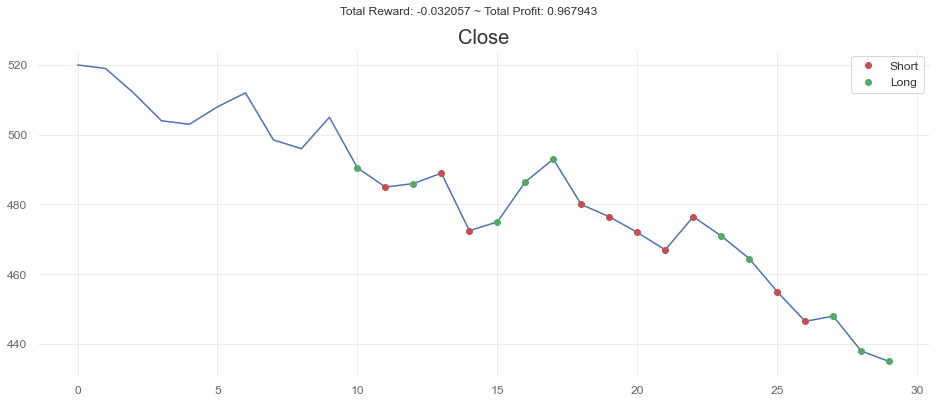

In [95]:
plt.figure(figsize=(16, 6))
env.render_Close()#將「環境」畫出來

# 根據模型預測，position為今天收盤時需要進行的交易策略(Long or Short)

↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓


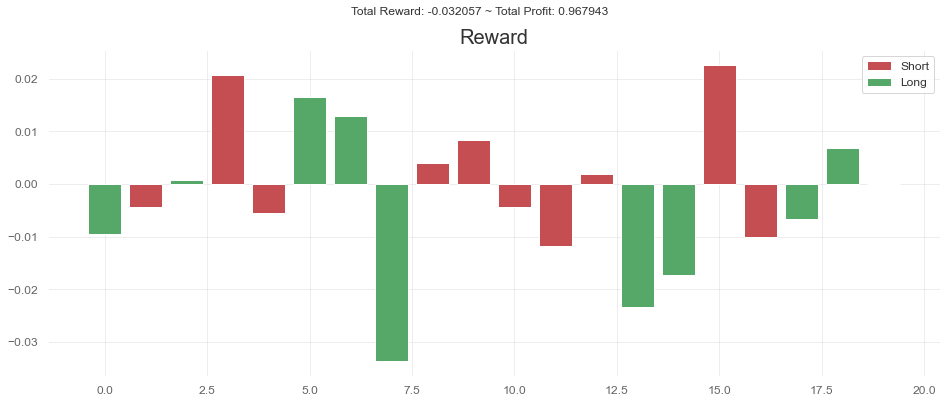

In [96]:
plt.figure(figsize=(16, 6))
env.render_Reward()

↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓


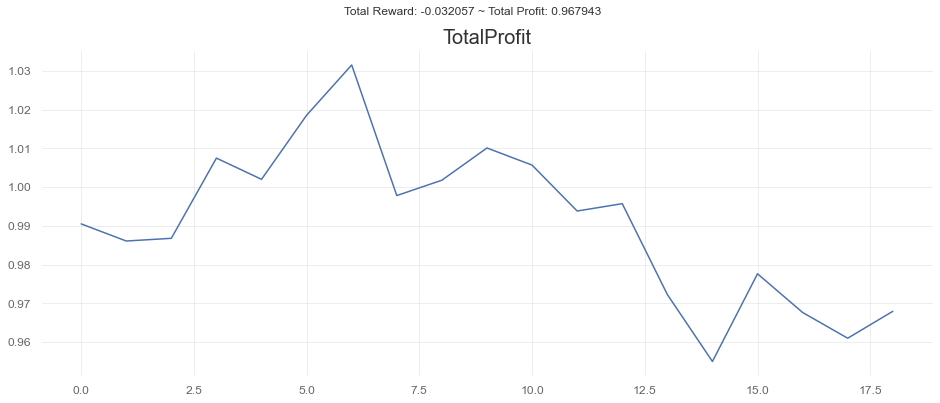

In [97]:
plt.figure(figsize=(16, 6))
env.render_TotalProfit()

# ------------------------------------------------

# 不同技術分析合併進行資料萃取，需要轉換矩陣格式，解釋如下：

In [2]:
# a = np.array([
#     [
#         [1,2,3,4,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6]
#     ]
# ])
# #-----------------------
# b = np.array([
#     [
#         [1,2],[3,4],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ]
# ])
# #-----------------------
# print('目的：將原本矩陣a，變成矩陣b。因為在機器訓練時，需要讓機器意識到為兩組獨立的參數')
# print('注意：入面組嘅大小必須相同，例如[1,2],[3,4]，但不可以[1,2],[3,4,5]\n\n')
# print('第一個數字：大括號\n第二個數字：有四個打橫\n第三個數字：打橫入面有幾多個數字')
# print(a.shape)
# print(a,'\n')
# print('第一個數字：有幾多大組嘅數字\n第二個數字：入面有幾多個小組\n第三個數字：每個小組入面有幾多個數字')
# print(b.shape)
# print(b)

In [11]:
open, close, high, low, volume, signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#「環境」整合
obs = env.reset()#初始化「環境」（特徵初始化）
env.seed()
Day = 0
while True: 
    obs = obs[np.newaxis, ...]#1.先抓取【0】~【9】的特徵
    action, _states = model.predict(obs)#2.Agent觀看obs, 進行action的行為，即買【1】賣【0】
    obs, rewards, done, info = env.step(action)#3.使用【1】~【10】的特徵'記錄'獎罰，驗證是否完成，輸出資料
    Day+=1
    print("Day",Day, "Rewards", rewards, end="\n")
    if done:#4.如果完成迴圈，則輸出資料
        print("info", info)
        break

Day 1 Rewards 2609.8624999999884
Day 2 Rewards -590.7374999999884
Day 3 Rewards -1897.7687499999884
Day 4 Rewards 3599.5125000000116
Day 5 Rewards 2087.381250000006
Day 6 Rewards 1580.3874999999825
Day 7 Rewards -586.3125
Day 8 Rewards -919.1812499999942
Day 9 Rewards -7886.556249999994
Day 10 Rewards -888.2062500000175
Day 11 Rewards -615.0750000000116
Day 12 Rewards -883.78125
Day 13 Rewards 125.78125
Day 14 Rewards -1871.21875
Day 15 Rewards 143.48125000001164
Day 16 Rewards 143.48125000001164
Day 17 Rewards 1148.6187499999942
Day 18 Rewards 3138.9812500000116
Day 19 Rewards -859.4437500000058
Day 20 Rewards 1122.0687500000058
Day 21 Rewards 132.41875000001164
Day 22 Rewards -639.4124999999767
Day 23 Rewards 1144.1937500000058
Day 24 Rewards -643.8375000000233
Day 25 Rewards -632.7750000000233
Day 26 Rewards -628.3499999999767
Day 27 Rewards -2856.443750000006
Day 28 Rewards -839.53125
Day 29 Rewards -657.1124999999884
Day 30 Rewards 158.96875
Day 31 Rewards -826.2562500000058
Day 3

Day 263 Rewards -885.9937499999942
Day 264 Rewards 2111.71875
Day 265 Rewards 2113.931249999994
Day 266 Rewards -363.51249999998254
Day 267 Rewards -637.2000000000116
Day 268 Rewards -1860.15625
Day 269 Rewards 4631.1999999999825
Day 270 Rewards -354.6625000000058
Day 271 Rewards -841.7437499999942
Day 272 Rewards -1337.6749999999884
Day 273 Rewards 2660.75
Day 274 Rewards 2162.6062499999825
Day 275 Rewards 1166.3187500000058
Day 276 Rewards -661.5374999999767
Day 277 Rewards -341.38749999998254
Day 278 Rewards 167.81875000000582
Day 279 Rewards 1157.46875
Day 280 Rewards -1319.9750000000058
Day 281 Rewards -319.26249999998254
Day 282 Rewards 1677.7375000000175
Day 283 Rewards -674.8125
Day 284 Rewards 1668.8874999999825
Day 285 Rewards -672.5999999999767
Day 286 Rewards -677.0250000000233
Day 287 Rewards -683.6624999999767
Day 288 Rewards -808.5562499999942
Day 289 Rewards 1686.5874999999942
Day 290 Rewards -312.625
Day 291 Rewards -2796.7062500000175
Day 292 Rewards -701.362499999988

Day 530 Rewards 1314.5562499999942
Day 531 Rewards -682.4437500000058
Day 532 Rewards -669.1687499999825
Day 533 Rewards 1321.1937500000058
Day 534 Rewards -669.1687499999825
Day 535 Rewards 1338.8937499999884
Day 536 Rewards -847.3875000000116
Day 537 Rewards 349.2437499999942
Day 538 Rewards 3353.59375
Day 539 Rewards 2350.6687499999825
Day 540 Rewards 2350.6687499999825
Day 541 Rewards -1140.7625000000116
Day 542 Rewards -1138.5499999999884
Day 543 Rewards -860.6624999999767
Day 544 Rewards -148.89999999999418
Day 545 Rewards 1345.53125
Day 546 Rewards 338.1812499999942
Day 547 Rewards -854.0250000000233
Day 548 Rewards 349.2437499999942
Day 549 Rewards -845.1749999999884
Day 550 Rewards -840.75
Day 551 Rewards -1343.3187500000058
Day 552 Rewards 2339.6062499999825
Day 553 Rewards 2839.962499999994
Day 554 Rewards -836.3250000000116
Day 555 Rewards 331.54375000001164
Day 556 Rewards 1330.0437500000116
Day 557 Rewards -825.2625000000116
Day 558 Rewards 329.33124999998836
Day 559 Rewa

Day 787 Rewards 4597.681249999994
Day 788 Rewards -3076.7000000000116
Day 789 Rewards -2407.306249999994
Day 790 Rewards -1402.1687500000116
Day 791 Rewards 4577.7687500000175
Day 792 Rewards -2905.4499999999825
Day 793 Rewards 1582.2687499999884
Day 794 Rewards 90.05000000001746
Day 795 Rewards 599.2562500000058
Day 796 Rewards 87.83749999999418
Day 797 Rewards 2576.34375
Day 798 Rewards 1575.6312500000058
Day 799 Rewards -441.28125
Day 800 Rewards -2932.0
Day 801 Rewards 17520.65625
Day 802 Rewards 3504.0437500000116
Day 803 Rewards 2496.693750000006
Day 804 Rewards 2498.90625
Day 805 Rewards -995.625
Day 806 Rewards -2006.5125000000116
Day 807 Rewards -7.300000000017462
Day 808 Rewards -1004.4749999999767
Day 809 Rewards 2979.350000000006
Day 810 Rewards 477.5687500000058
Day 811 Rewards -1005.7999999999884
Day 812 Rewards 490.84375
Day 813 Rewards 510.7562500000058
Day 814 Rewards -478.89375000001746
Day 815 Rewards -1475.1812500000233
Day 816 Rewards -463.40625
Day 817 Rewards 532

Day 1073 Rewards 25.887499999982538
Day 1074 Rewards -1042.0875000000233
Day 1075 Rewards 1551.2937500000116
Day 1076 Rewards -3950.4124999999767
Day 1077 Rewards 4526.881250000006
Day 1078 Rewards -4452.981250000012
Day 1079 Rewards -1062.0
Day 1080 Rewards -1081.9124999999767
Day 1081 Rewards 4575.556249999994
Day 1082 Rewards 2556.431249999994
Day 1083 Rewards 5527.59375
Day 1084 Rewards 34.73750000001746
Day 1085 Rewards -5931.924999999988
Day 1086 Rewards 3072.274999999994
Day 1087 Rewards -1904.7374999999884
Day 1088 Rewards 8571.768749999988
Day 1089 Rewards -1066.4249999999884
Day 1090 Rewards 4542.368749999994
Day 1091 Rewards -456.76875000001746
Day 1092 Rewards 67.92500000001746
Day 1093 Rewards -5418.2937499999825
Day 1094 Rewards 103.32499999998254
Day 1095 Rewards 6083.262500000012
Day 1096 Rewards -919.5125000000116
Day 1097 Rewards 581.5562499999942
Day 1098 Rewards 4064.1375000000116
Day 1099 Rewards 2069.350000000006
Day 1100 Rewards 74.5625
Day 1101 Rewards -1895.887